Lybraries

In [1218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report,accuracy_score,ConfusionMatrixDisplay,confusion_matrix,precision_score,recall_score,roc_curve,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from tensorflow import keras
import datetime
from dataclasses import dataclass
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from scipy.ndimage import gaussian_filter1d
from itertools import combinations as comb
from pyts.image import RecurrencePlot
import PIL



### EDA

In [871]:
train_path='data/test_motion_data.csv'
test_path='data/train_motion_data.csv'

#### Train data

In [872]:
train_data=pd.read_csv(train_path)
train_data.head(1)

AccX      AccY      AccZ  GyroX  GyroY  GyroZ       Class  Timestamp
0  0.758194 -0.217791  0.457263    0.0    0.0    0.0  AGGRESSIVE     818922

In [958]:
train_data.describe()

AccX         AccY         AccZ        GyroX        GyroY  \
count  3084.000000  3084.000000  3084.000000  3084.000000  3084.000000   
mean      0.106234    -0.131791     0.045011     0.003192     0.001452   
std       0.968089     0.904398     0.997625     0.066636     0.120963   
min      -4.854163    -7.621754    -6.106982    -0.514959    -1.309466   
25%      -0.408916    -0.625868    -0.461438    -0.024435    -0.045739   
50%       0.051892    -0.096929     0.054154     0.001222    -0.000993   
75%       0.579148     0.393118     0.575119     0.028100     0.043601   
max       5.864980     4.308813     5.564037     1.490511     1.707598   

             GyroZ      Timestamp   class_code      Acc_mod  
count  3084.000000    3084.000000  3084.000000  3084.000000  
mean      0.011472  819830.000324     1.148833     1.390087  
std       0.113535     525.760733     0.809185     2.212003  
min      -0.976315  818922.000000     0.000000     0.001947  
25%      -0.027031  819338.000000     0.000000     0.296732  
50%       0.002291  819832.500000     1.000000     0.718270  
75%       0.035888  820292.250000     2.000000     1.615076  
max       0.719447  820709.000000     2.000000    35.329019

In [874]:
train_data.isna().sum()

AccX         0
AccY         0
AccZ         0
GyroX        0
GyroY        0
GyroZ        0
Class        0
Timestamp    0
dtype: int64

In [875]:
train_data=train_data.sort_values(by='Timestamp')

In [876]:
train_data.Timestamp.unique().shape

(1667,)

There are roughly 2 measurements per second

In [877]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3084 entries, 0 to 3083
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AccX       3084 non-null   float64
 1   AccY       3084 non-null   float64
 2   AccZ       3084 non-null   float64
 3   GyroX      3084 non-null   float64
 4   GyroY      3084 non-null   float64
 5   GyroZ      3084 non-null   float64
 6   Class      3084 non-null   object 
 7   Timestamp  3084 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 216.8+ KB


In [878]:
train_data.Timestamp.value_counts().describe()

count    1667.000000
mean        1.850030
std         0.357149
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: Timestamp, dtype: float64

It proves that there is not a single timestamp that is replicated many times.

In [879]:
train_data.columns

Index(['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'Class',
       'Timestamp'],
      dtype='object')

In [880]:
train_data['Timestamp']=train_data['Timestamp'].astype('int')

train_data['Class']=train_data['Class'].astype('category')
train_data['class_code']=train_data['Class'].cat.codes

In [881]:
var_columns=['AccX','AccY','AccZ','GyroX','GyroY','GyroZ']
label_columns=['class_code','Class']

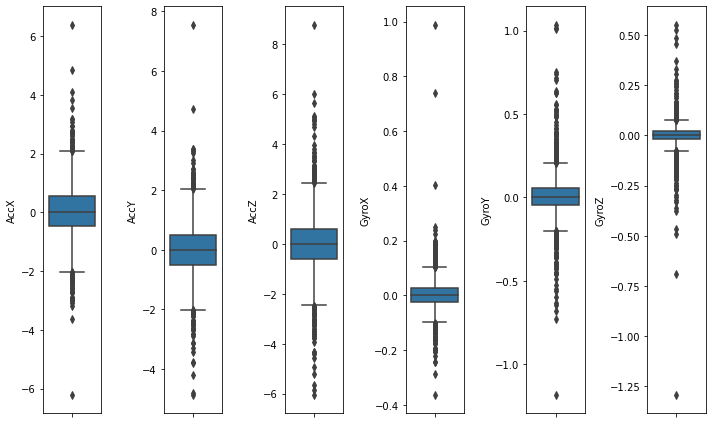

In [882]:
index=(train_data.Timestamp.value_counts()>1).index
measument1=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=measument1-measument2
fig,axes=plt.subplots(1,len(var_columns),figsize=(10,6))
for column,ax in zip(var_columns,axes.flatten()):    
    sns.boxplot(data=diff,y=column,ax=ax)
plt.tight_layout()

There are a lot of outliers, e.i., There is many measuments in the same timestamp that are desagreeing badly. However, it might be due to is amplitude. Then lets take a look in the boxplot normalized. 

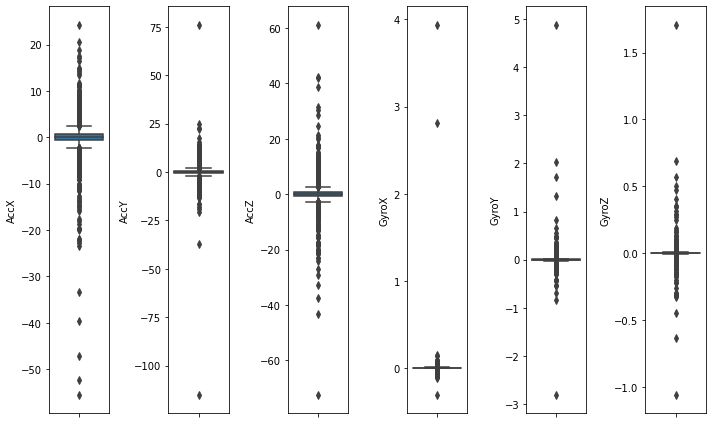

In [883]:
index=(train_data.Timestamp.value_counts()>1).index
measument1=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=(measument1-measument2)/0.5*(measument2+measument1)
fig,axes=plt.subplots(1,len(var_columns),figsize=(10,6))
for column,ax in zip(var_columns,axes.flatten()):    
    sns.boxplot(data=diff,y=column,ax=ax)
plt.tight_layout()

The gyroscope data is not desagreeing much. But, the accelaration that It massive desagreement in some measuments. 
 


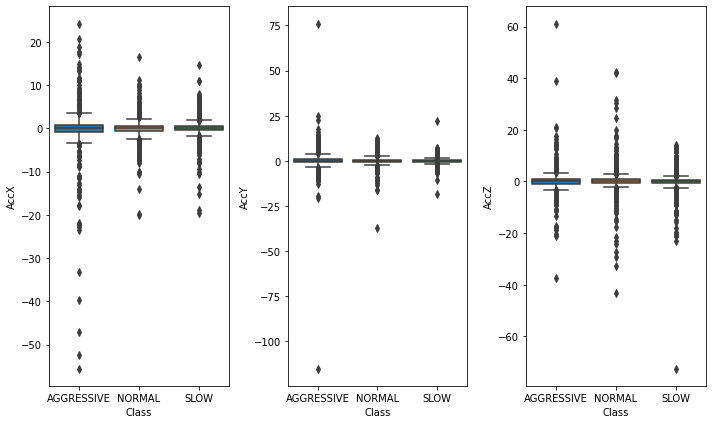

In [884]:
index=(train_data.Timestamp.value_counts()>1).index
measument1=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=(measument1-measument2)/0.5*(measument2+measument1)
diff=diff.reset_index().merge(train_data.drop_duplicates('Timestamp')[['Timestamp','Class']],right_on='Timestamp',left_on='index')
used_columns=[column for column in var_columns if 'Acc' in column]
fig,axes=plt.subplots(1,len(used_columns),figsize=(10,6))
for column,ax in zip(used_columns,axes.flatten()):
    sns.boxplot(data=diff,y=column,ax=ax,x='Class')
plt.tight_layout()

level of agreeament

[1]Bland, J. Martin, and DouglasG Altman. "Statistical methods for assessing agreement between two methods of clinical measurement." The lancet 327.8476 (1986): 307-310.


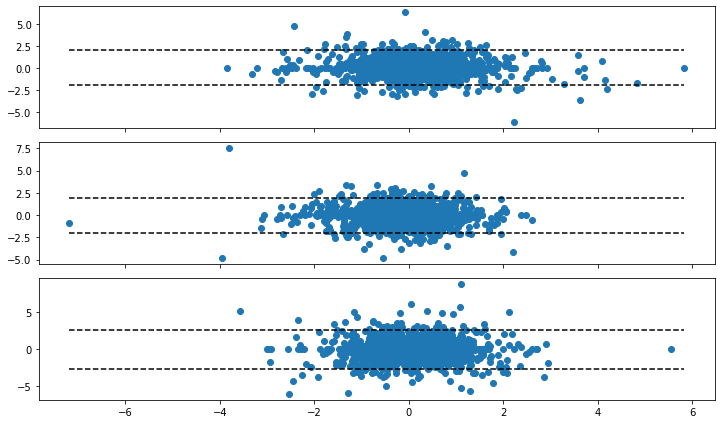

In [885]:
index=(train_data.Timestamp.value_counts()>1).index
measument1=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=measument1-measument2
mean=(measument1+measument2)*0.5
used_columns=[column for column in var_columns if 'Acc' in column]
fig,axes=plt.subplots(len(used_columns),1,figsize=(10,6),sharex=True)
for column,ax in zip(used_columns,axes.flatten()):    
    ax.scatter(x=mean[column],y=diff[column])
    ax.hlines(np.mean(diff[column])+2*np.std(diff[column]),mean[used_columns].min().min(),mean[used_columns].max().max(),linestyles='dashed',color='black')
    ax.hlines(np.mean(diff[column])-2*np.std(diff[column]),mean[used_columns].min().min(),mean[used_columns].max().max(),linestyles='dashed',color='black')
plt.tight_layout()


Even though, the data are quite odd and show significant different, Using [1] one might argui that both data agree.

Also, With this it seems that there is not a specific range where the data desagree more.

Since both measures may have differnt signs I will be taken the mean of its module, I wonder if there is some behaviour hidden due it. 

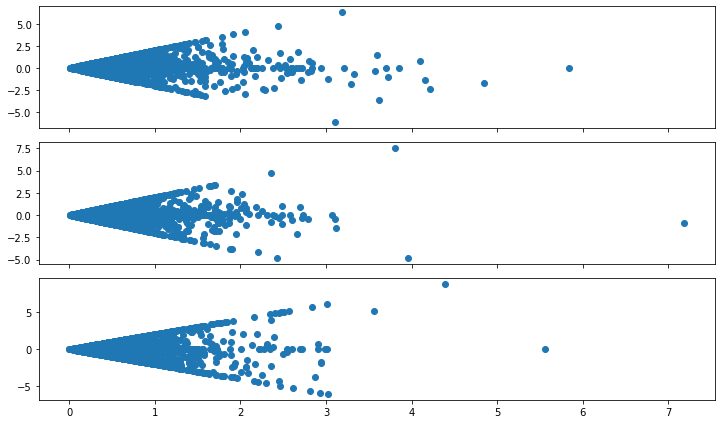

In [886]:
index=(train_data.Timestamp.value_counts()>1).index
measument1=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=measument1-measument2
mean=(np.abs(measument1)+np.abs(measument2))*0.5
used_columns=[column for column in var_columns if 'Acc' in column]
fig,axes=plt.subplots(len(used_columns),1,figsize=(10,6),sharex=True)
for column,ax in zip(used_columns,axes.flatten()):    
    ax.scatter(x=mean[column],y=diff[column])

plt.tight_layout()


Adding new features.

In [887]:
train_data['Acc_mod']=0.5*(train_data['AccX']**2+train_data['AccY']**2+train_data['AccZ']**2)
var_columns.append('Acc_mod')

Dataset balance

<AxesSubplot:>

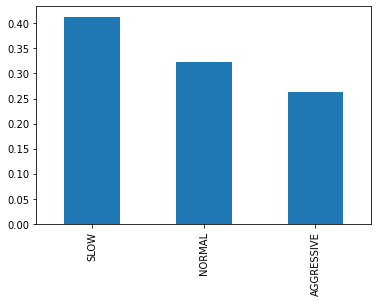

In [888]:
train_data['Class'].value_counts(normalize=True).plot(kind='bar')

Data aumentation

In [889]:
missing_seconds=set(train_data['Timestamp'].unique()).difference(set(range(train_data['Timestamp'].min(),train_data['Timestamp'].max()+1)))
missing_seconds

set()

With this we ensure the signal continuity

Bellow, it has been created some code for fixing some possible descontinuity

In [890]:
avaible_seconds=train_data.Timestamp.unique()

for second in missing_seconds:
    new_index=len(train_data)+1
    train_data.loc[new_index,['Timestamp']]=[second]
    train_data.loc[new_index,var_columns]=[np.nan]*len(var_columns)
   
    for offset in range(1,11):
        filled=False
        if second-offset in avaible_seconds:
            train_data.loc[new_index,label_columns]=train_data.drop_duplicates('Timestamp').set_index('Timestamp').loc[second-offset,label_columns]
            filled=True
            break
        elif second+offset in avaible_seconds:
            train_data.loc[new_index,label_columns]=train_data.drop_duplicates('Timestamp').set_index('Timestamp').loc[second+offset,label_columns]
            filled=True
            break

    if not filled: print('Method did not work')
    train_data.loc[new_index,label_columns]=[np.nan]*len(label_columns)
    
train_data=train_data.sort_values('Timestamp').reset_index(drop=True)
train_data[var_columns]=train_data[var_columns].interpolate(method='polynomial',order=5)[var_columns]=train_data[var_columns].interpolate(method='linear')

Observing the data as a signal

In [891]:
train_data['Class'].map({'SLOW':'green','NORMAL':'blue','AGGRESSIVE':'red'}).value_counts()

green    1273
blue      997
red       814
Name: Class, dtype: int64

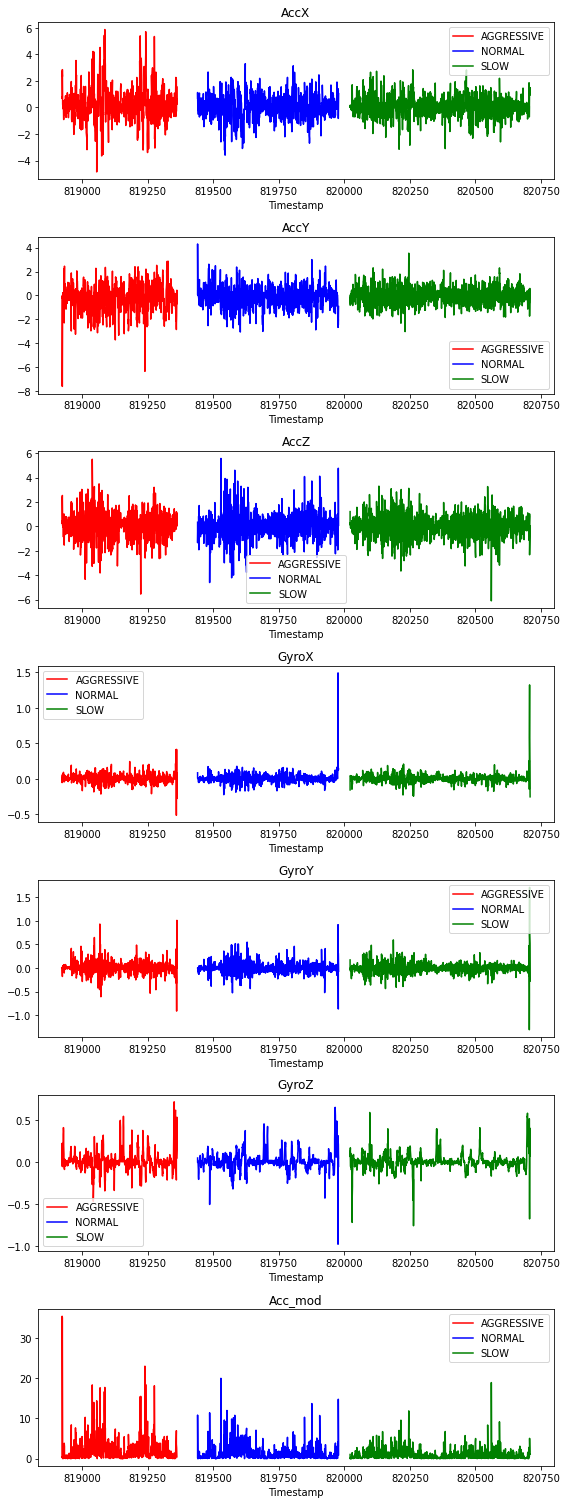

In [892]:
fig,axes=plt.subplots(len(var_columns),1,figsize=(8,3*len(var_columns)))

for ax,column in zip (axes.flatten(),var_columns):
    grouped=train_data.groupby('Class')
    color={'SLOW':'green','NORMAL':'blue','AGGRESSIVE':'red'}
    for key,group in grouped:
        group.plot(ax=ax,x='Timestamp',y=column,label=key,color=color[key])
    ax.set_title(column)
plt.tight_layout()

FFT

In [893]:
def fourier_analysis(data,fft_ax,psd_ax,prefix=''):
    fft=np.fft.fft(data)
    freq=np.fft.fftfreq(len(data),d=1)

    fft_ax.plot(freq,fft.real,color='red',alpha=0.5,label='real')
    fft_ax.plot(freq,fft.imag,color='blue',alpha=0.6,label='imag')
    fft_ax.set_xlim(left=0)
    fft_ax.set_title(prefix+' FFT')
    fft_ax.legend()
    psd=(1/len(data))*(fft.real**2+fft.imag**2)
    psd_ax.set_title(prefix+' PSD')
    psd_ax.plot(freq,psd,color='blue',alpha=0.7)
    psd_ax.set_xlim(left=-0.01)
    

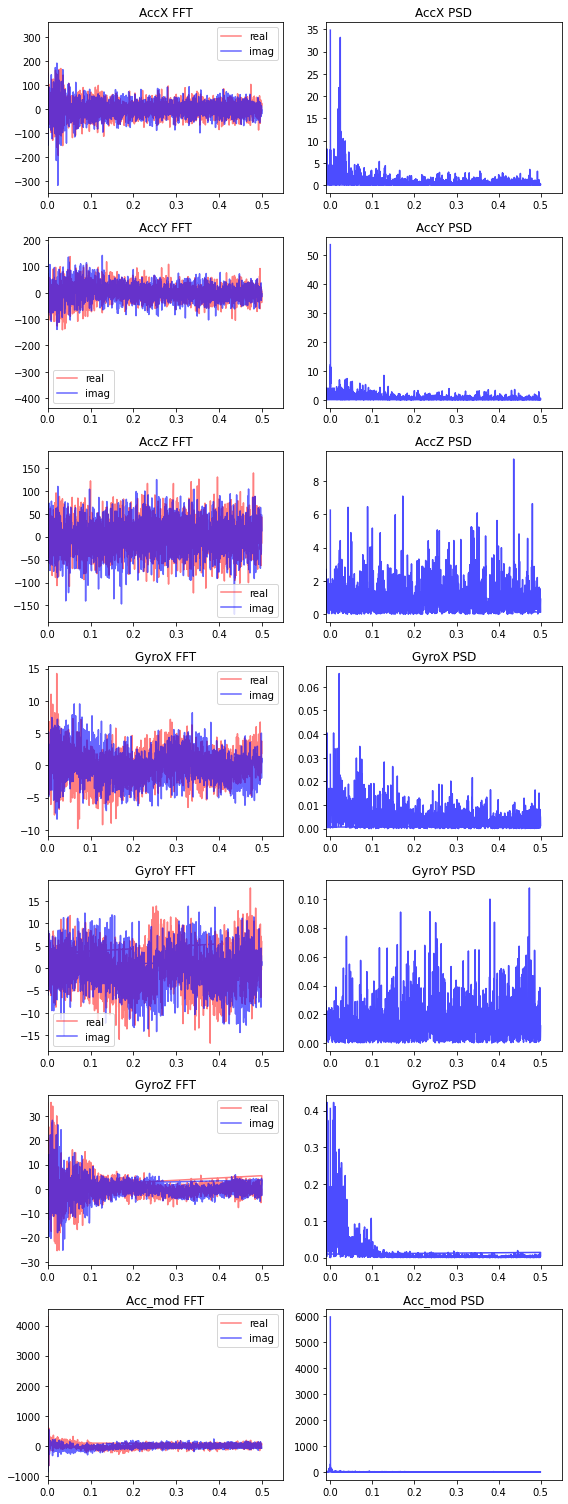

In [894]:
fig,axes=plt.subplots(len(var_columns),2,figsize=(8,3*len(var_columns)))

for ax,column in zip (axes,var_columns):
    fourier_analysis(train_data[column],ax[0],ax[1],prefix=column)
plt.tight_layout()

Looking the fft of each class, since showed before, there are three continuos periods in data

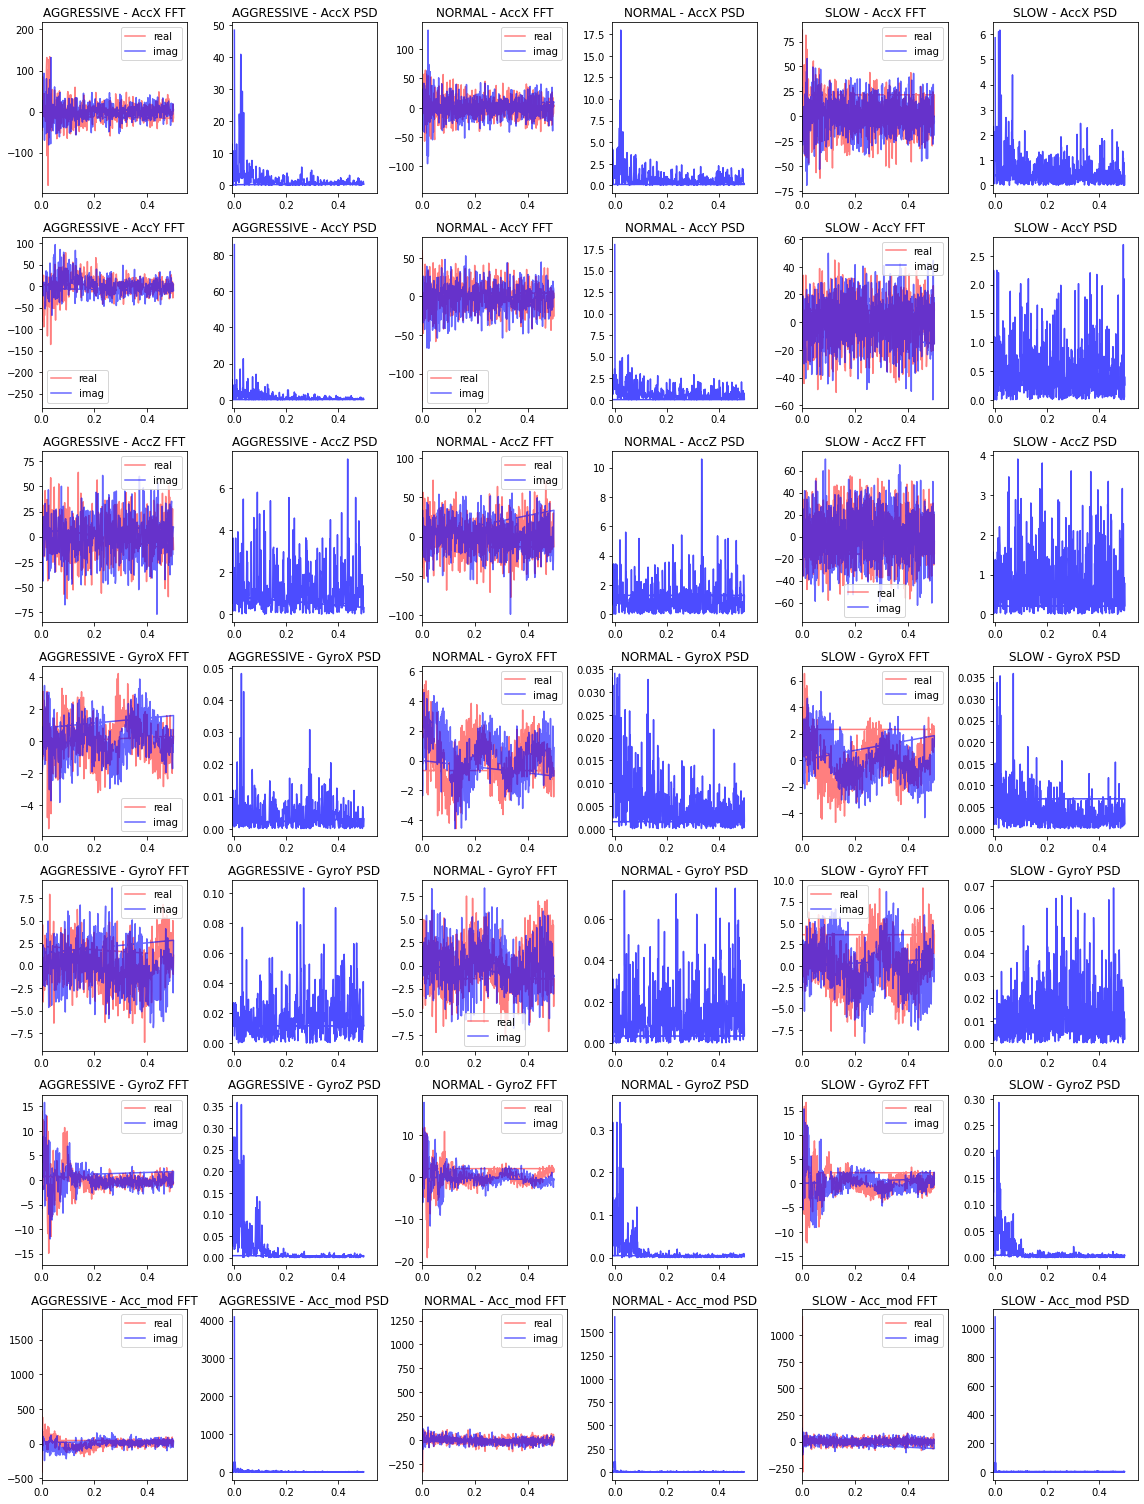

In [895]:
fig,axes=plt.subplots(len(var_columns),6,figsize=(16,3*len(var_columns)))

for ax,column in zip (axes,var_columns):
    grouped=train_data.groupby('Class')
    for groupd_index,(key,group) in enumerate(grouped):
        data=grouped.get_group(key)[column]
        fourier_analysis(data,ax[groupd_index*2],ax[groupd_index*2+1],prefix=f'{key} - {column}')
plt.tight_layout()

spectogram

In [896]:
def spectogram_analysis(data,ax,prefix=''):
    f, t, Sxx = signal.spectrogram(data, 1)
    im=ax.pcolormesh(t, f, Sxx, shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_title(prefix)
    plt.colorbar(im,ax=ax)

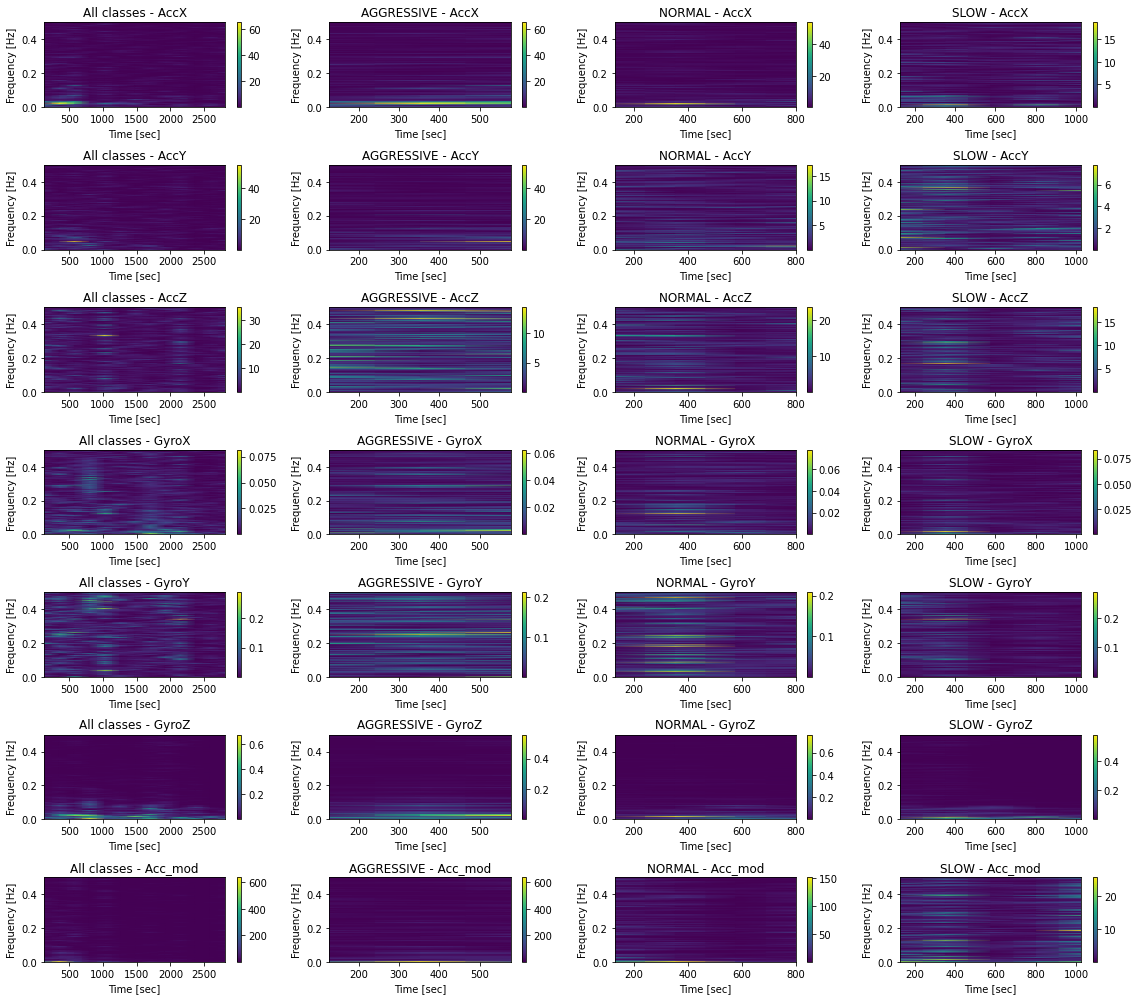

In [897]:
fig,axes=plt.subplots(len(var_columns),4,figsize=(16,2*len(var_columns)))

for ax,column in zip (axes,var_columns):
    data=train_data[column]
    spectogram_analysis(data,ax[0],f'All classes - {column}')
    grouped=train_data.groupby('Class')
    for groupd_index,(key,group) in enumerate(grouped):
        data=group[column]
        spectogram_analysis(data,ax[groupd_index+1],prefix=f'{key} - {column}')
plt.tight_layout()

#### Test data - The previus analysys was replicated

In [898]:
test_data=pd.read_csv(test_path)
test_data.head(1)

AccX  AccY  AccZ     GyroX     GyroY     GyroZ   Class  Timestamp
0   0.0   0.0   0.0  0.059407 -0.174707  0.101938  NORMAL    3581629

In [899]:
test_data.describe()

AccX         AccY         AccZ        GyroX        GyroY  \
count  3644.000000  3644.000000  3644.000000  3644.000000  3644.000000   
mean      0.040467    -0.073418     0.008271     0.001593    -0.001273   
std       0.985653     0.903408     0.985061     0.066918     0.126205   
min      -4.636523    -4.699795    -7.143998    -0.751822    -1.587028   
25%      -0.550695    -0.592540    -0.558464    -0.028558    -0.053756   
50%       0.003931    -0.080833     0.002262     0.001985    -0.001833   
75%       0.595987     0.452401     0.556157     0.031918     0.051313   
max       4.985548     4.245151     5.171739     0.849255     1.679879   

             GyroZ     Timestamp  
count  3644.000000  3.644000e+03  
mean      0.007949  3.582707e+06  
std       0.115687  6.421479e+02  
min      -1.236468  3.581629e+06  
25%      -0.029398  3.582121e+06  
50%       0.002978  3.582702e+06  
75%       0.040852  3.583270e+06  
max       1.190500  3.583791e+06

In [900]:
test_data.isna().sum()

AccX         0
AccY         0
AccZ         0
GyroX        0
GyroY        0
GyroZ        0
Class        0
Timestamp    0
dtype: int64

In [901]:
test_data=test_data.sort_values(by='Timestamp')

In [902]:
test_data.Timestamp.unique().shape

(1968,)

There are roughly 2 measurements per second

In [903]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3644 entries, 0 to 3643
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AccX       3644 non-null   float64
 1   AccY       3644 non-null   float64
 2   AccZ       3644 non-null   float64
 3   GyroX      3644 non-null   float64
 4   GyroY      3644 non-null   float64
 5   GyroZ      3644 non-null   float64
 6   Class      3644 non-null   object 
 7   Timestamp  3644 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 256.2+ KB


In [904]:
test_data.Timestamp.value_counts().describe()

count    1968.000000
mean        1.851626
std         0.355561
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: Timestamp, dtype: float64

It proves that there is not a single timestamp that is replicated many times.

In [905]:
test_data.columns

Index(['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'Class',
       'Timestamp'],
      dtype='object')

In [906]:
test_data['Timestamp']=test_data['Timestamp'].astype('int')

test_data['Class']=test_data['Class'].astype('category')
test_data['class_code']=test_data['Class'].cat.codes

In [907]:
var_columns=['AccX','AccY','AccZ','GyroX','GyroY','GyroZ']
label_columns=['class_code','Class']

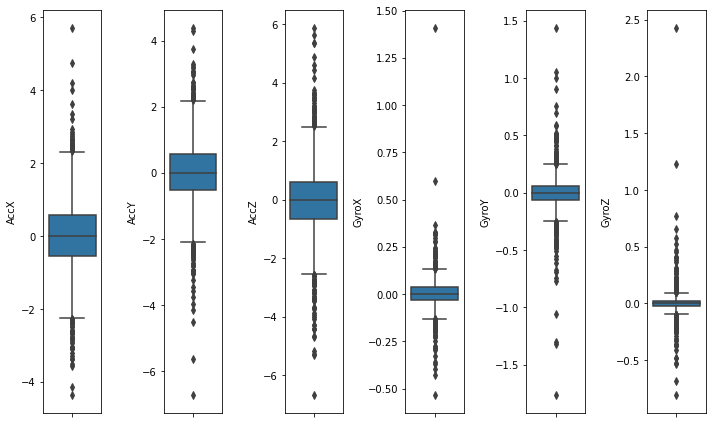

In [908]:
index=(test_data.Timestamp.value_counts()>1).index
measument1=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=measument1-measument2
fig,axes=plt.subplots(1,len(var_columns),figsize=(10,6))
for column,ax in zip(var_columns,axes.flatten()):    
    sns.boxplot(data=diff,y=column,ax=ax)
plt.tight_layout()

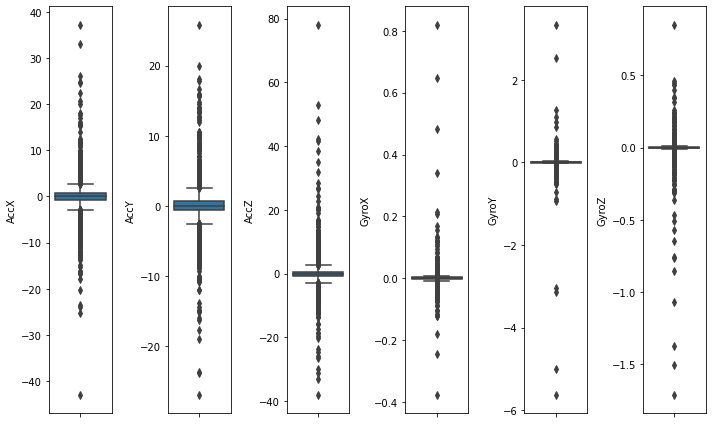

In [909]:
index=(test_data.Timestamp.value_counts()>1).index
measument1=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=(measument1-measument2)/0.5*(measument2+measument1)
fig,axes=plt.subplots(1,len(var_columns),figsize=(10,6))
for column,ax in zip(var_columns,axes.flatten()):    
    sns.boxplot(data=diff,y=column,ax=ax)
plt.tight_layout()

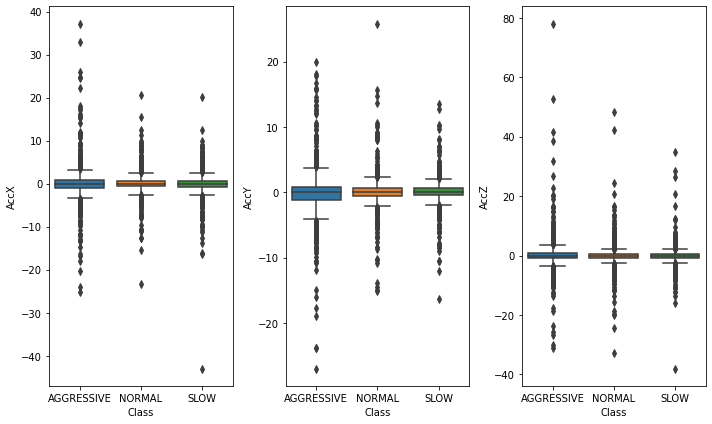

In [910]:
index=(test_data.Timestamp.value_counts()>1).index
measument1=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=(measument1-measument2)/0.5*(measument2+measument1)
diff=diff.reset_index().merge(test_data.drop_duplicates('Timestamp')[['Timestamp','Class']],right_on='Timestamp',left_on='index')
used_columns=[column for column in var_columns if 'Acc' in column]
fig,axes=plt.subplots(1,len(used_columns),figsize=(10,6))
for column,ax in zip(used_columns,axes.flatten()):
    sns.boxplot(data=diff,y=column,ax=ax,x='Class')
plt.tight_layout()

level of agreeament

[1]Bland, J. Martin, and DouglasG Altman. "Statistical methods for assessing agreement between two methods of clinical measurement." The lancet 327.8476 (1986): 307-310.


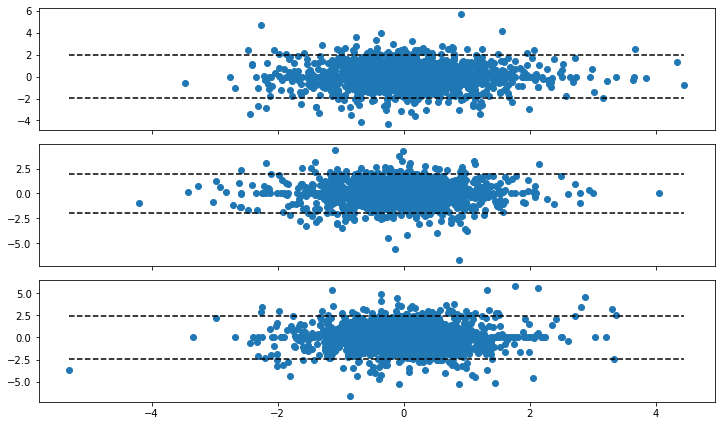

In [911]:
index=(test_data.Timestamp.value_counts()>1).index
measument1=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=measument1-measument2
mean=(measument1+measument2)*0.5
used_columns=[column for column in var_columns if 'Acc' in column]
fig,axes=plt.subplots(len(used_columns),1,figsize=(10,6),sharex=True)
for column,ax in zip(used_columns,axes.flatten()):    
    ax.scatter(x=mean[column],y=diff[column])
    ax.hlines(np.mean(diff[column])+2*np.std(diff[column]),mean[used_columns].min().min(),mean[used_columns].max().max(),linestyles='dashed',color='black')
    ax.hlines(np.mean(diff[column])-2*np.std(diff[column]),mean[used_columns].min().min(),mean[used_columns].max().max(),linestyles='dashed',color='black')
plt.tight_layout()


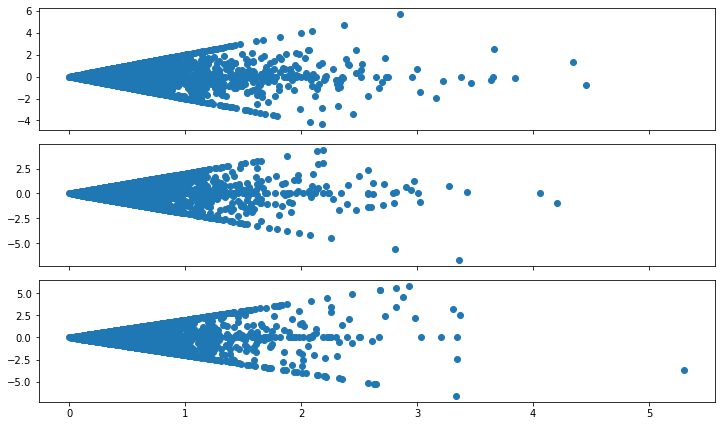

In [912]:
index=(test_data.Timestamp.value_counts()>1).index
measument1=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=measument1-measument2
mean=(np.abs(measument1)+np.abs(measument2))*0.5
used_columns=[column for column in var_columns if 'Acc' in column]
fig,axes=plt.subplots(len(used_columns),1,figsize=(10,6),sharex=True)
for column,ax in zip(used_columns,axes.flatten()):    
    ax.scatter(x=mean[column],y=diff[column])

plt.tight_layout()


Adding new features.

In [913]:
test_data['Acc_mod']=0.5*(test_data['AccX']**2+test_data['AccY']**2+test_data['AccZ']**2)
var_columns.append('Acc_mod')

Dataset balance

<AxesSubplot:>

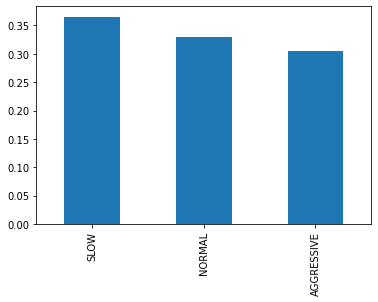

In [914]:
test_data['Class'].value_counts(normalize=True).plot(kind='bar')

Data aumentation

In [915]:
missing_seconds=set(test_data['Timestamp'].unique()).difference(set(range(test_data['Timestamp'].min(),test_data['Timestamp'].max()+1)))
missing_seconds

set()

With this we ensure the signal continuity

Observing the data as a signal

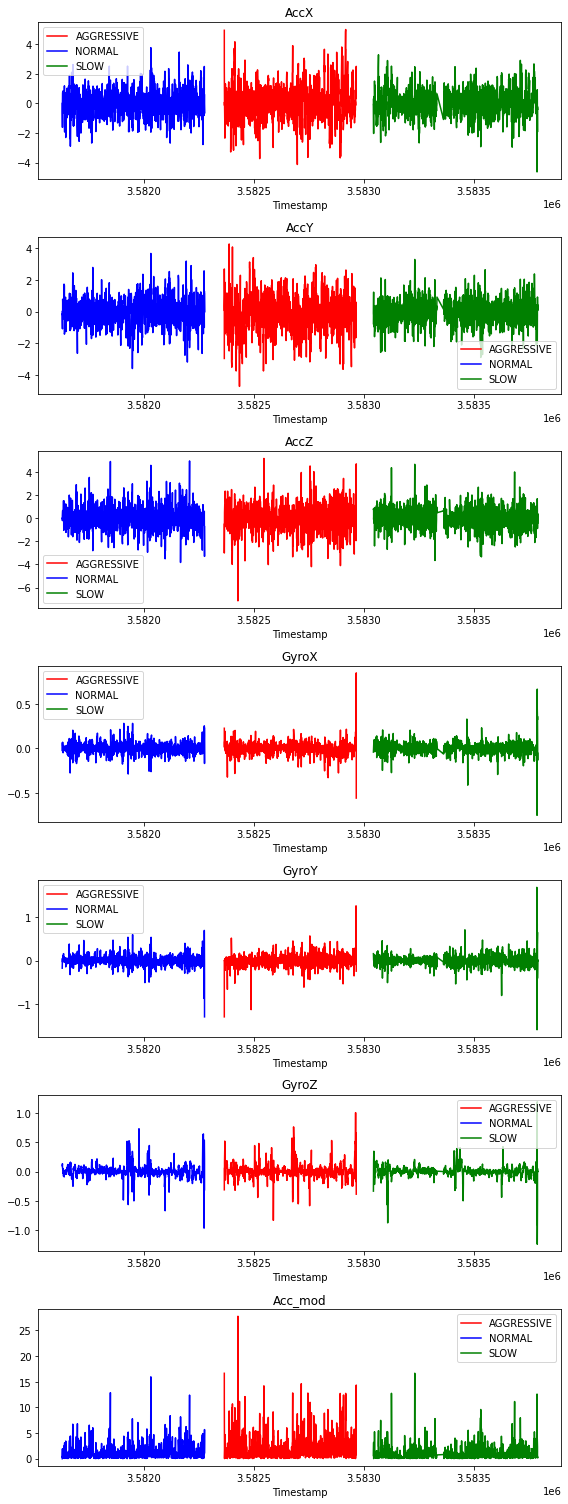

In [916]:
fig,axes=plt.subplots(len(var_columns),1,figsize=(8,3*len(var_columns)))

for ax,column in zip (axes.flatten(),var_columns):
    grouped=test_data.groupby('Class')
    color={'SLOW':'green','NORMAL':'blue','AGGRESSIVE':'red'}
    for key,group in grouped:
        group.plot(ax=ax,x='Timestamp',y=column,label=key,color=color[key])
    ax.set_title(column)
plt.tight_layout()

FFT

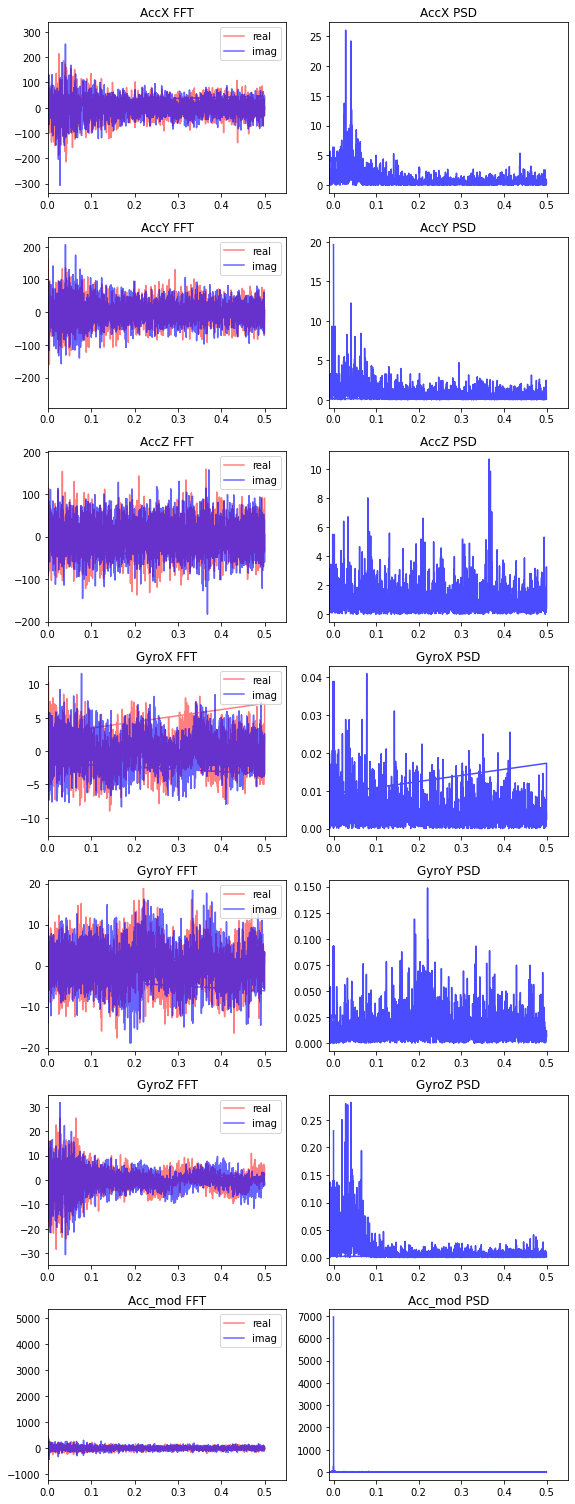

In [917]:
fig,axes=plt.subplots(len(var_columns),2,figsize=(8,3*len(var_columns)))

for ax,column in zip (axes,var_columns):
    fourier_analysis(test_data[column],ax[0],ax[1],prefix=column)
plt.tight_layout()

Looking the fft of each class, since showed before, there are three continuos periods in data

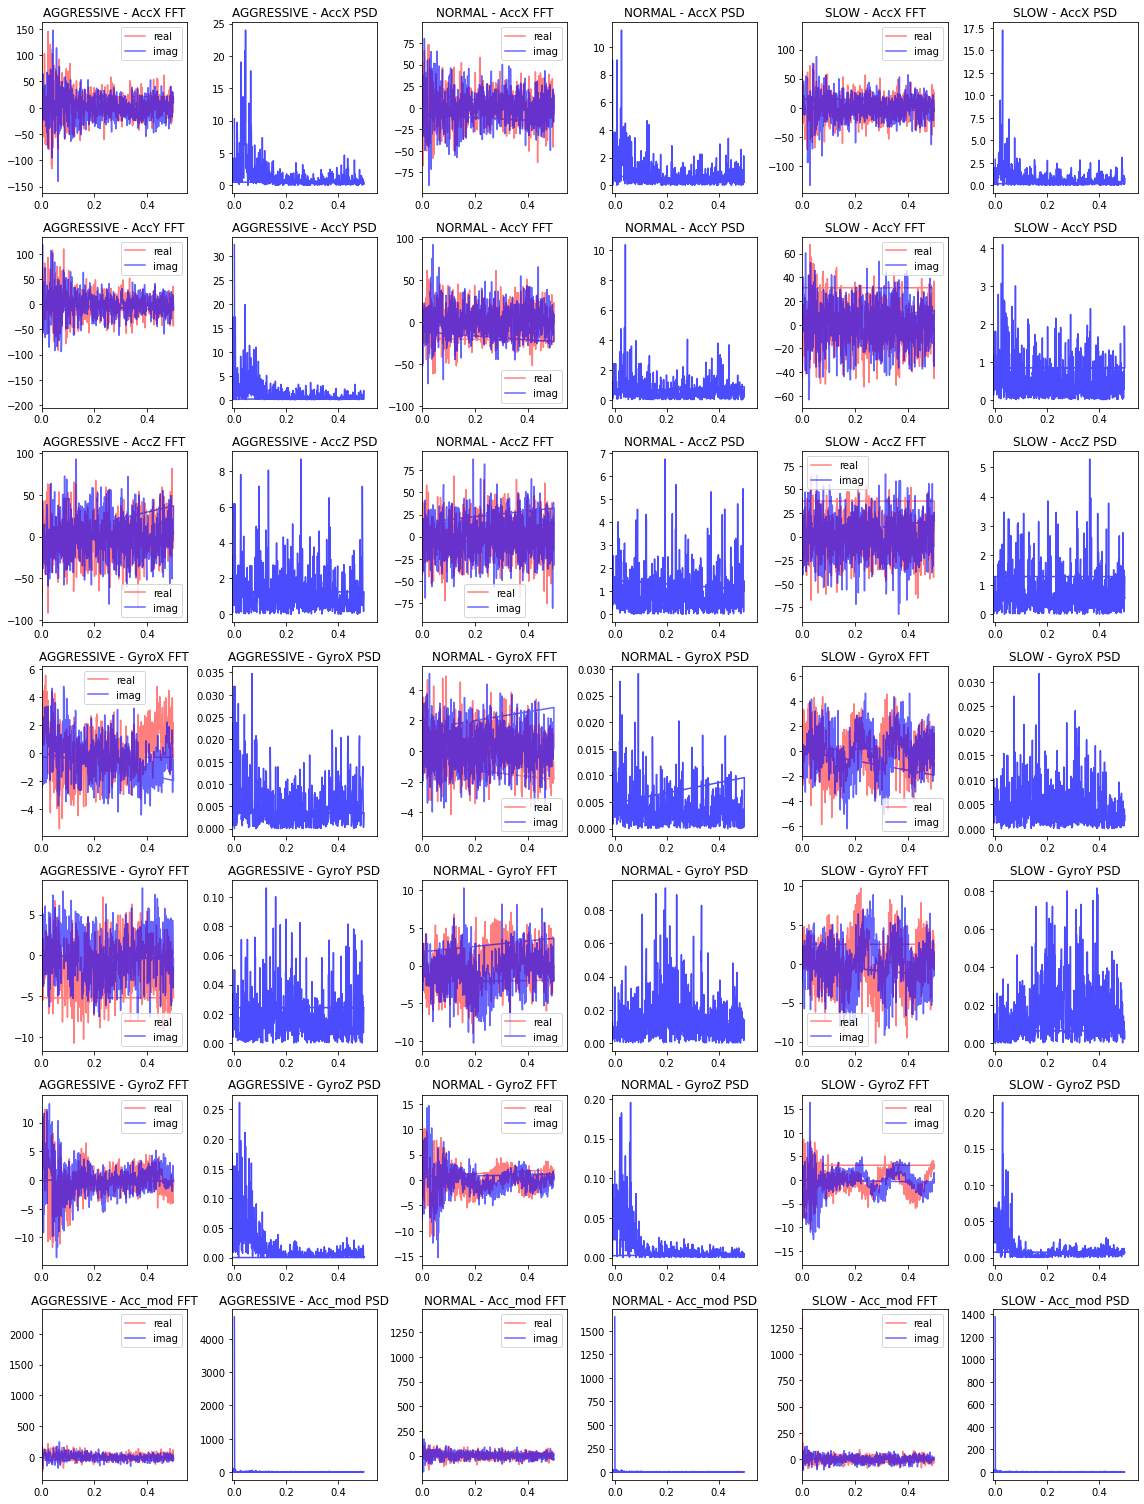

In [918]:
fig,axes=plt.subplots(len(var_columns),6,figsize=(16,3*len(var_columns)))

for ax,column in zip (axes,var_columns):
    grouped=test_data.groupby('Class')
    for groupd_index,(key,group) in enumerate(grouped):
        data=grouped.get_group(key)[column]
        fourier_analysis(data,ax[groupd_index*2],ax[groupd_index*2+1],prefix=f'{key} - {column}')
plt.tight_layout()

spectogram

In [919]:
def spectogram_analysis(data,ax,prefix=''):
    f, t, Sxx = signal.spectrogram(data, 1)
    im=ax.pcolormesh(t, f, Sxx, shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_title(prefix)
    plt.colorbar(im,ax=ax)

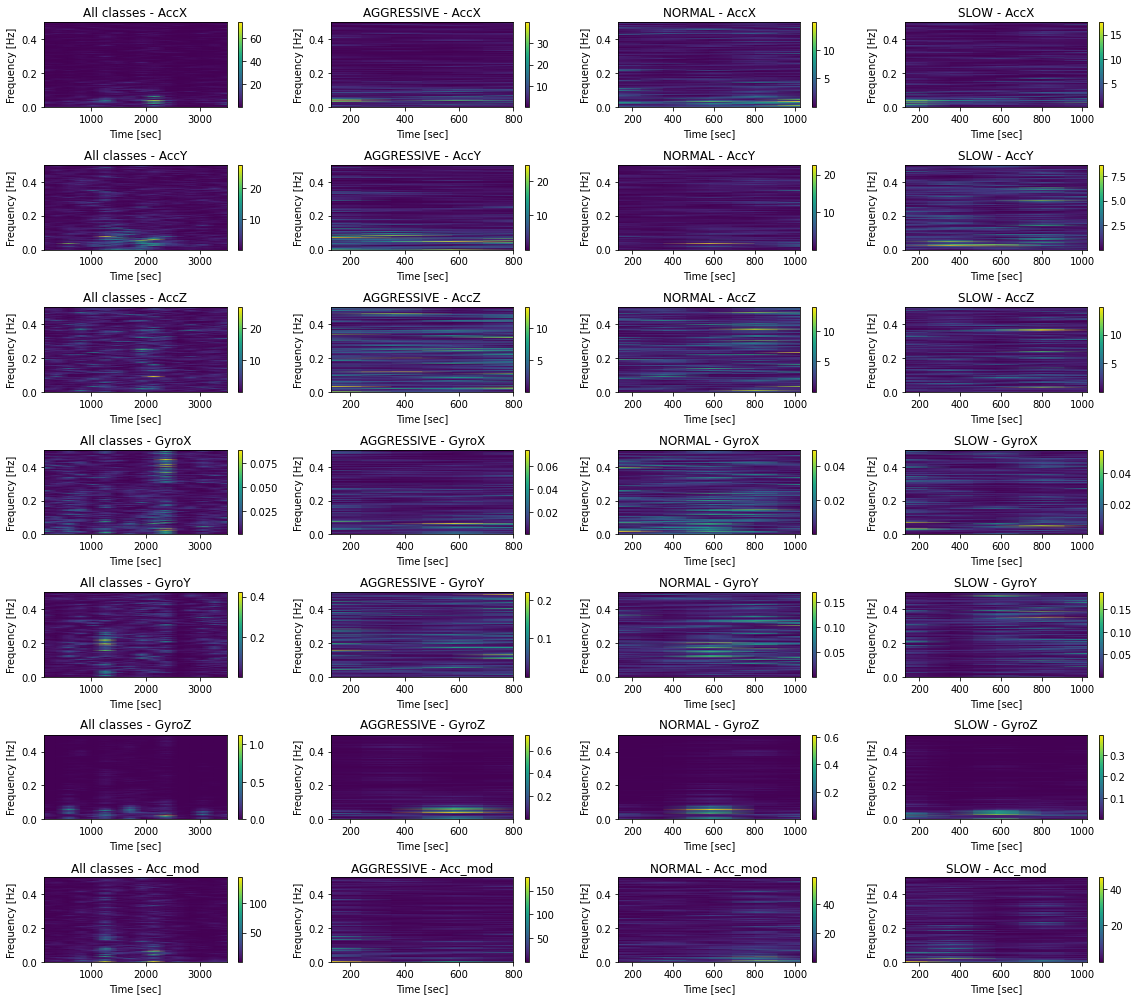

In [920]:
fig,axes=plt.subplots(len(var_columns),4,figsize=(16,2*len(var_columns)))

for ax,column in zip (axes,var_columns):
    data=test_data[column]
    spectogram_analysis(data,ax[0],f'All classes - {column}')
    grouped=test_data.groupby('Class')
    for groupd_index,(key,group) in enumerate(grouped):
        data=group[column]
        spectogram_analysis(data,ax[groupd_index+1],prefix=f'{key} - {column}')
plt.tight_layout()

### Data processing to aplly AI

Denoising data

In [921]:

def split_numeric_categoric_data(df):

    return df[var_columns],df[label_columns]


def rooling_average(df:pd.DataFrame,window):
    df_numeric,df_labels=split_numeric_categoric_data(df)
    df_smoothed=df_numeric.rolling(window).mean()    
    return pd.concat([df_smoothed,df_labels],axis=1)

def exponential_smoothing(df:pd.DataFrame,alpha):
    df_numeric,df_labels=split_numeric_categoric_data(df)
    df_smoothed=df_numeric.ewm(alpha=alpha).mean()
    return pd.concat([df_smoothed,df_labels],axis=1)
   
def gaussian_smoothing(df:pd.DataFrame,window,std):
    df_numeric,df_labels=split_numeric_categoric_data(df)
    df_smoothed=df_numeric.rolling(window,win_type='gaussian',center=True).mean(std=std)
    return pd.concat([df_smoothed,df_labels],axis=1)

Display of each smoothing method

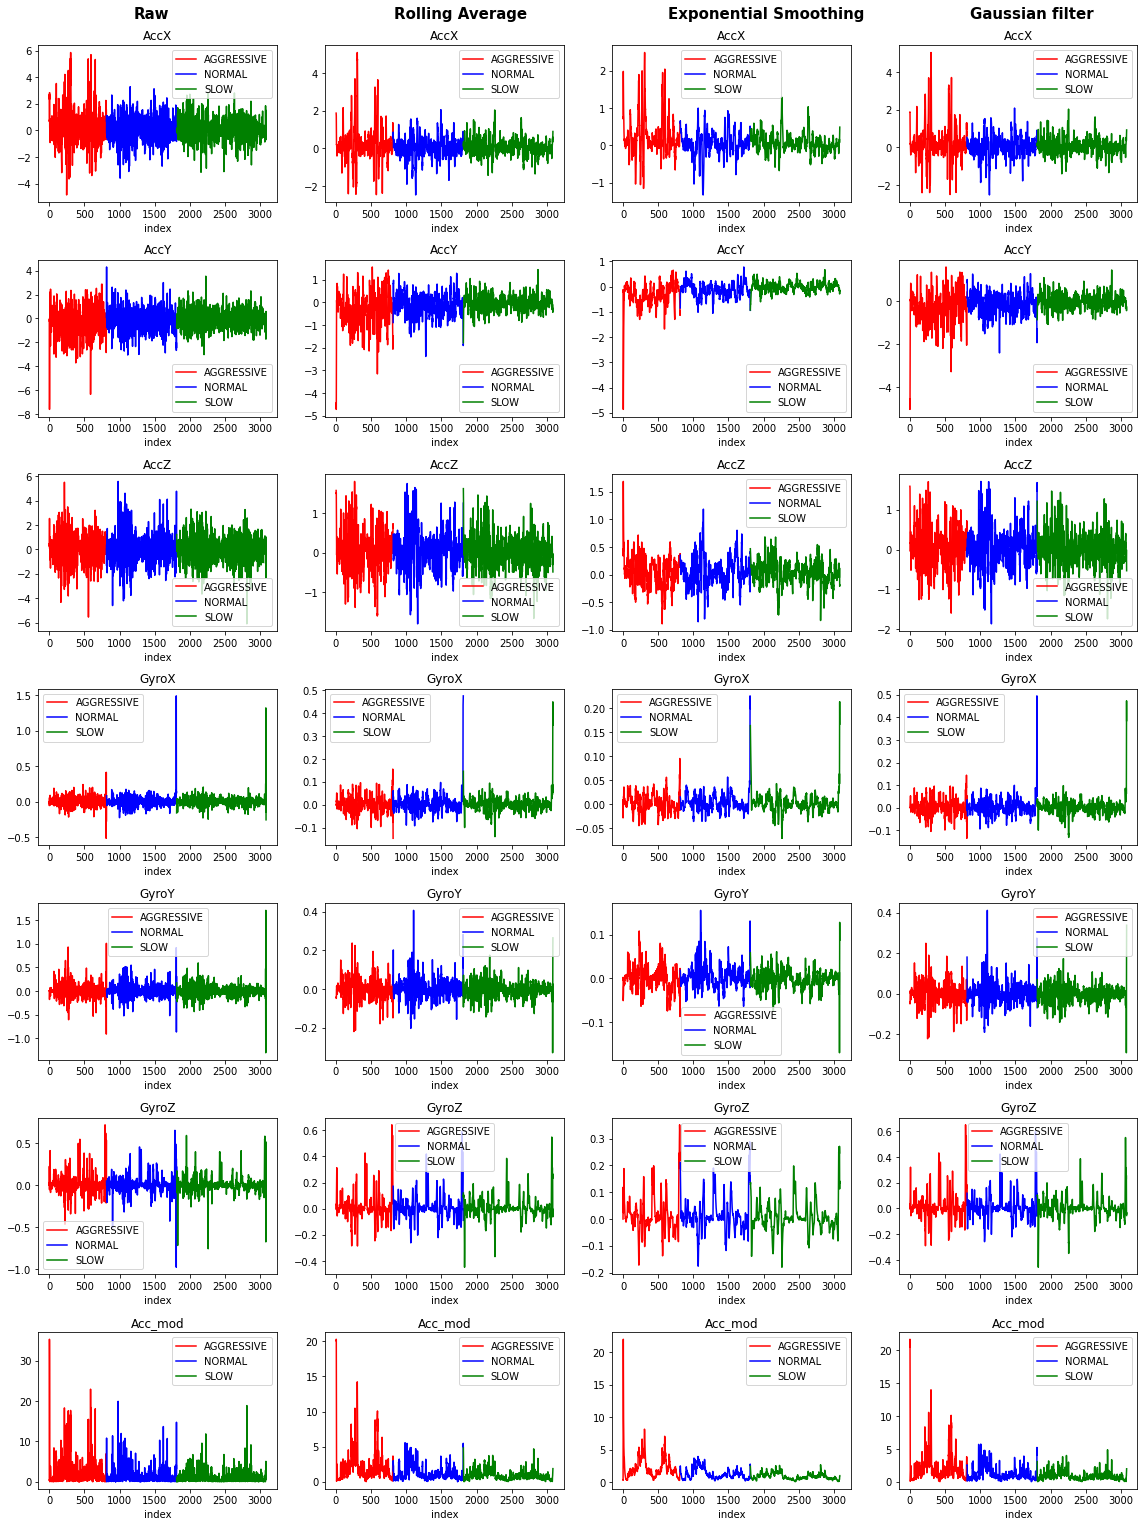

In [922]:
denoised_dfs=[train_data.reset_index()\
              ,rooling_average(train_data,5).reset_index()\
              ,exponential_smoothing(train_data,0.1).reset_index()\
              ,gaussian_smoothing(train_data,5,3).reset_index()\
]
denoise_methods_label=['Raw','Rolling Average','Exponential Smoothing','Gaussian filter']

fig,axes=plt.subplots(len(var_columns),4,figsize=(16,3*len(var_columns)))

for df,(index,label) in zip(denoised_dfs,enumerate(denoise_methods_label)):
    for ax,column in zip (axes[:,index].flatten(),var_columns):
        grouped=df.groupby('Class')
        color={'SLOW':'green','NORMAL':'blue','AGGRESSIVE':'red'}
        for key,group in grouped:
            group.plot(ax=ax,x='index',y=column,label=key,color=color[key])
        ax.set_title(column)
    fig.text(.125-0.002*len(label)+0.25*index,1,label,fontsize=15,weight='bold')
plt.tight_layout()

The models that will be built aims to find which data are related to agressive driving, then, it will became a binary classification problem.

The input data should be a sequence of seconds, since the acceleration of a given seconds does not provide enough information about the driving beahaviour

Data loader

In [1151]:
@dataclass
class DataLoader:
    train_df:pd.DataFrame
    test_df:pd.DataFrame
    var_columns:list
    class_column:list
    seed=123    

    def smoothing(self,method='rolling_average',**kwargs):        
        """
        method: either 'gaussian','exponential','rolling_average'
        """
        
        if method=='exponential':
            func=DataLoader.__exponential_smoothing
        elif method=='gaussian':
            func=DataLoader.__gaussian_smoothing
        else:
            func=DataLoader.__rooling_average
        
        self.train_df=self.__apply_smoothing(self.train_df,func,kwargs)
        self.test_df=self.__apply_smoothing(self.test_df,func,kwargs)
    
    def __apply_smoothing(self,df,func,func_kwargs):
        df_numeric,df_labels=df[self.var_columns],df[self.class_column]
        df_numeric=func(df_numeric,**func_kwargs)
        return pd.concat([df_numeric,df_labels],axis=1).dropna()
    
    @staticmethod
    def __rooling_average(df:pd.DataFrame,window):
        df_smoothed=df.rolling(window).mean()
        return df_smoothed

    @staticmethod
    def __exponential_smoothing(df:pd.DataFrame,alpha):
        df_smoothed=df.ewm(alpha=alpha).mean()
        return df_smoothed
    
    @staticmethod
    def __gaussian_smoothing(df:pd.DataFrame,window,std):
        df_smoothed=df.rolling(window,win_type='gaussian',center=True).mean(std=std)
        return df_smoothed

    def __get_val_data(self):  
        np.random.seed(self.seed)                 
        X,Y=self.test_df[self.var_columns].values,self.test_df[self.class_column].values
        self.Xtest,self.Xval,self.Ytest,self.Yval=train_test_split(X,Y,test_size=.5,stratify=Y)     

    def __get_val_data_sequence(self):   
        np.random.seed(self.seed)        
        X,Y=self.XtestSequence,self.YtestSequence
        self.XtestSequence,self.XvalSequence,self.YtestSequence,self.YvalSequence=train_test_split(X,Y,test_size=.5,stratify=Y)     
    
    def __create_sequences(self,df,sequence_size):
        X=[]
        Y=[]
        for key in df[self.class_column[0]].unique():
            train_class=df[df[self.class_column[0]]==key]  
            for row_shift in range(sequence_size):
                size=(len(train_class)-row_shift)//sequence_size*sequence_size
                X_temp=train_class[var_columns].values[row_shift:size+row_shift]\
                                                .reshape(-1,len(var_columns),sequence_size)
                Y_temp=np.array([key]*len(X_temp)).reshape(-1,1)
                if len(X)!=0:
                    X=np.vstack((X,X_temp))
                    Y=np.vstack((Y,Y_temp))
                else:
                    X=X_temp
                    Y=Y_temp
        return X,Y

    def get_train_val_test_arrays(self):
        self.Xtrain=self.train_df[self.var_columns].values
        self.Ytrain=self.train_df[self.class_column].values
        self.__get_val_data()
        return self.Xtrain,self.Ytrain,self.Xval,self.Yval,self.Xtest,self.Ytest
    
    def get_train_val_test_sequence(self):
        self.__get_val_data_sequence()
        return self.XtrainSequence,self.YtrainSequence,self.XvalSequence,self.YvalSequence,self.XtestSequence,self.YtestSequence
    
    def to_sequecence(self,sequence_size):
        self.XtrainSequence,self.YtrainSequence=self.__create_sequences(self.train_df,sequence_size)
        self.XtestSequence,self.YtestSequence=self.__create_sequences(self.test_df,sequence_size)
        

    
    def to_binary_classes(self,map):
        self.train_df[self.class_column[0]]=self.train_df[self.class_column[0]].map(map)
        self.test_df[self.class_column[0]]=self.test_df[self.class_column[0]].map(map)


In [1152]:
dataloader=DataLoader(train_data.copy(),test_data.copy(),var_columns,['class_code'])
map={0:1,2:0,1:0}
dataloader.to_binary_classes(map)
dataloader.smoothing('gaussian',window=5,std=3)
X_train,Y_train,X_val,Y_val,X_test,Y_test=dataloader.get_train_val_test_arrays()


In [1081]:
train_data[label_columns].value_counts()


class_code  Class     
2           SLOW          1273
1           NORMAL         997
0           AGGRESSIVE     814
dtype: int64

In [1082]:
np.unique(Y_train,return_counts=True)

(array([0, 1], dtype=int64), array([2268,  812], dtype=int64))

In [1083]:
test_data[label_columns].value_counts()


class_code  Class     
2           SLOW          1331
1           NORMAL        1200
0           AGGRESSIVE    1113
dtype: int64

In [1084]:
print(np.unique(Y_val,return_counts=True),np.unique(Y_test,return_counts=True))

(array([0, 1], dtype=int64), array([1264,  556], dtype=int64)) (array([0, 1], dtype=int64), array([1263,  557], dtype=int64))


In [1153]:
dataloader.to_sequecence(3)
X_trainSequence,Y_trainSequence,X_valSequence,Y_valSequence,X_testSequence,Y_testSequence=dataloader.get_train_val_test_sequence()

In [1154]:
X_trainSequence.shape

(3076, 7, 3)

In [1053]:
np.unique(Y_trainSequence,return_counts=True)

(array([0, 1], dtype=int64), array([3078, 3078], dtype=int64))

### Models

In [932]:
class ClassificationModel():
    def __init__(self,model,Xtrain,Ytrain,scaler=False,random_state=123,**kwargs):
        self.random_state=random_state
        if scaler:
            self.model=make_pipeline(StandardScaler(),model(**kwargs))
        else:
            self.model=model(**kwargs)
        self.Xtrain=Xtrain
        self.Ytrain=Ytrain
        self._get_label_proportion(Ytrain,prefix='train')
        
    
    def fit(self):      
        np.random.seed(self.random_state)  
        self.model.fit(self.Xtrain,self.Ytrain)

    def evaluate(self,Xtest,Ytest):
        self._get_label_proportion(Ytest,prefix='test')
        self.pred=self.model.predict(Xtest)
        self._get_accuracy(Ytest)
        self._get_confusion_matrix(Ytest)
        self._get_class_report(Ytest)

    def _get_confusion_matrix(self,Ytest):
        cm = confusion_matrix(Ytest,self.pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
    
    def _get_class_report(self,Ytest):
        report=classification_report(Ytest,self.pred)
        print(report)

    def _get_accuracy(self,Ytest):
        accuracy=accuracy_score(Ytest,self.pred)
        print(f'The accuracy observed was {accuracy*100:.0f} %')
    
    def _get_label_proportion(self,Y,prefix=''):
        true_rate=(sum(Y==1)/len(Y))[0]
        print(f'{prefix}: The dataset has {true_rate*100:.0f}% of positive')
    

### Machine learning

Logistic Regression

train: The dataset has 26% of positive


c:\Users\estevan.amazonas\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test: The dataset has 31% of positive
The accuracy observed was 73 %
              precision    recall  f1-score   support

           0       0.73      0.97      0.83      1264
           1       0.71      0.19      0.29       556

    accuracy                           0.73      1820
   macro avg       0.72      0.58      0.56      1820
weighted avg       0.72      0.73      0.67      1820



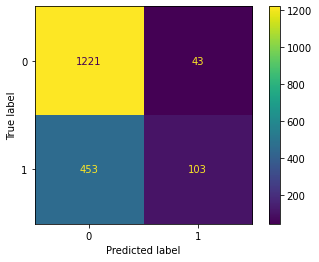

In [933]:
LR=ClassificationModel(LogisticRegression,X_train,Y_train,n_jobs=-1)
LR.fit()
LR.evaluate(X_val,Y_val)

Scaled

train: The dataset has 26% of positive
test: The dataset has 31% of positive
The accuracy observed was 73 %
              precision    recall  f1-score   support

           0       0.73      0.96      0.83      1264
           1       0.71      0.20      0.31       556

    accuracy                           0.73      1820
   macro avg       0.72      0.58      0.57      1820
weighted avg       0.73      0.73      0.67      1820



c:\Users\estevan.amazonas\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


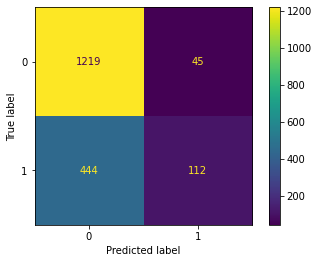

In [934]:
LR=ClassificationModel(LogisticRegression,X_train,Y_train,scaler=True)
LR.fit()
LR.evaluate(X_val,Y_val)

The dummiest classifier would guess everything negative and would have the same result.

SVM

train: The dataset has 26% of positive
test: The dataset has 31% of positive


c:\Users\estevan.amazonas\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The accuracy observed was 75 %
              precision    recall  f1-score   support

           0       0.75      0.96      0.84      1264
           1       0.76      0.25      0.38       556

    accuracy                           0.75      1820
   macro avg       0.75      0.61      0.61      1820
weighted avg       0.75      0.75      0.70      1820



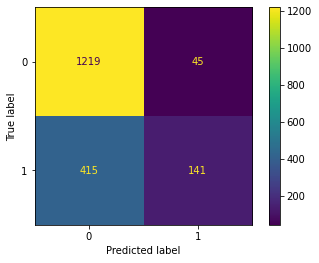

In [935]:
SVC_model=ClassificationModel(SVC,X_train,Y_train,scaler=True)
SVC_model.fit()
SVC_model.evaluate(X_val,Y_val)

Random Forest

train: The dataset has 26% of positive


c:\Users\estevan.amazonas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


test: The dataset has 31% of positive
The accuracy observed was 75 %
              precision    recall  f1-score   support

           0       0.76      0.93      0.84      1264
           1       0.67      0.33      0.44       556

    accuracy                           0.75      1820
   macro avg       0.72      0.63      0.64      1820
weighted avg       0.73      0.75      0.72      1820



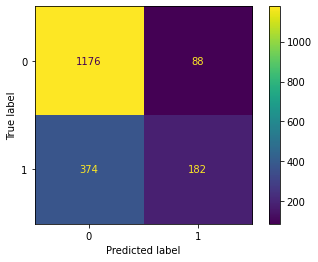

In [936]:
RF=ClassificationModel(RandomForestClassifier,X_train,Y_train,n_jobs=-1)
RF.fit()
RF.evaluate(X_val,Y_val)

Naive Bayes

train: The dataset has 26% of positive
test: The dataset has 31% of positive
The accuracy observed was 73 %
              precision    recall  f1-score   support

           0       0.75      0.91      0.83      1264
           1       0.62      0.33      0.43       556

    accuracy                           0.73      1820
   macro avg       0.69      0.62      0.63      1820
weighted avg       0.71      0.73      0.70      1820



c:\Users\estevan.amazonas\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


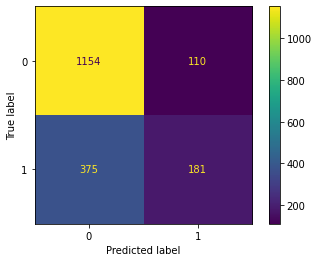

In [937]:
MB=ClassificationModel(GaussianNB,X_train,Y_train)
MB.fit()
MB.evaluate(X_val,Y_val)

Xgboost

train: The dataset has 26% of positive
test: The dataset has 31% of positive
The accuracy observed was 74 %
              precision    recall  f1-score   support

           0       0.77      0.90      0.83      1264
           1       0.63      0.39      0.48       556

    accuracy                           0.74      1820
   macro avg       0.70      0.64      0.66      1820
weighted avg       0.73      0.74      0.72      1820



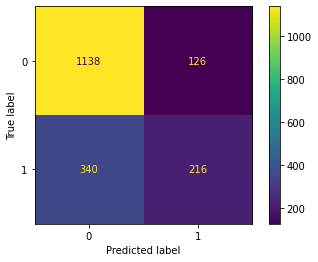

In [938]:
XGB=ClassificationModel(XGBClassifier,X_train,Y_train)
XGB.fit()
XGB.evaluate(X_val,Y_val)

None of the models have performed well, as it was mentioned before, our base line shloud be ~69%.

### Deep Learning

#### MLP

In [939]:
from abc import abstractclassmethod
class DLModel():

    def __init__(self,Xtrain,Ytrain,Xval,Yval,Xtest,Ytest):
        self.Xtrain=Xtrain
        self.Ytrain=Ytrain
        self.Xval=Xval
        self.Yval=Yval
        self.Xtest=Xtest
        self.Ytest=Ytest
        self.training_history=[]
        self.model=self.model_compiler()
    
    @property
    def architecture(self):
        return self.model.summary()
    
    @abstractclassmethod
    def model_compiler(self):
        pass

    @abstractclassmethod
    def train_params(self)->dict:
        pass   

    def train(self,seed=123,verbose=0):
        np.random.seed(seed)
        history=self.model.fit(self.Xtrain,self.Ytrain,validation_data=(self.Xval,self.Yval),verbose=verbose,**self.training_params())
        self.training_history.append(history)     

    def test(self):
        threshold=0.5
        self.predictions=self.model.predict(self.Xtest)
        self.binary_predictions=(self.predictions>threshold).astype(int)
        test_accuracy=accuracy_score(self.Ytest,self.binary_predictions)        
        test_precision=precision_score(self.Ytest,self.binary_predictions)
        test_recall=recall_score(self.Ytest,self.binary_predictions)
        auc=roc_auc_score(self.Ytest,self.binary_predictions)
        print(f'Test accuracy : {test_accuracy*100:.0f} %')
        print(f'Test precision : {test_precision*100:.0f} %')
        print(f'Test recall : {test_recall*100:.0f} %')
        print(f'Model AUC : {auc*100:.0f} %')
        self.confusion_matrix_plot()


    @staticmethod
    def __unpack_data_history(history_record,key):
        key=DLModel.__get_metric_key_by_prefix(key,history_record)
        metric=[]
        for train_data in history_record:
            metric.extend(train_data.history[key])
        
        return metric
    
    @staticmethod
    def __get_metric_key_by_prefix(key,history_record):
        key_in_history=''
        if 'val' in key:
            for metric in history_record[-1].history.keys():
                if key in metric:
                    key_in_history=metric
                    break
        else:
            for metric in history_record[-1].history.keys():
                if key in metric and 'val' not in metric:
                    key_in_history=metric
                    break

        return key_in_history

    def loss_plot(self,ax=None):
        if not ax:
            loss=DLModel.__unpack_data_history(self.training_history,'loss')
            plt.title('loss')
            plt.plot(loss)
            plt.xlabel('epochs')
            plt.show()
        else:
            pass

    def accuracy_plot(self,ax=None):
        if not ax:        
            accuracy=DLModel.__unpack_data_history(self.training_history,'binary_accuracy')
            val_accuracy=DLModel.__unpack_data_history(self.training_history,'val_binary_accuracy')
            plt.title('Accuracy')
            plt.plot(accuracy,label='train')
            plt.plot(val_accuracy,label='val')
            plt.legend()
            plt.xlabel('epochs')
            plt.grid(True)
            plt.show()
        else:
            pass


    def precision_recall_plot(self,ax=None):
        if not ax:
            precision=DLModel.__unpack_data_history(self.training_history,'precision')
            recall=DLModel.__unpack_data_history(self.training_history,'recall')
            val_precision=DLModel.__unpack_data_history(self.training_history,'val_precision')
            val_recall=DLModel.__unpack_data_history(self.training_history,'val_recall')
            plt.subplot(1,2,1)
            plt.title('Precision')
            plt.plot(precision,label='Train')
            plt.plot(val_precision,label='Val') 
            plt.xlabel('epochs')
            plt.legend()
            plt.subplot(1,2,2)
            plt.title('Recall')
            plt.plot(recall,label='Train')
            plt.plot(val_recall,label='Val') 
            plt.xlabel('epochs')
            plt.legend()
            plt.tight_layout()
            plt.show()
        else:
            pass
    
    
    def confusion_matrix_plot(self):
        if hasattr(self, 'predictions'):
            cm = confusion_matrix(self.Ytest,self.binary_predictions)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot()
        else:
            print('Test method should be called before')

    def plot_all_training_metrics(self):
        self.loss_plot()
        self.accuracy_plot()
        self.precision_recall_plot()

    def multiple_seeds_analysis(self,seeds:list):
        pass
          



model 1

In [940]:
class model_1(DLModel):
    def __init__(self,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)

    def model_compiler(self):
        MLP_model=keras.Sequential(
                [
                
                    keras.Input(shape=(7,)),
                    keras.layers.Dense(10,activation='tanh', kernel_initializer="glorot_uniform"),
                    keras.layers.Dense(10,activation='tanh'),
                    keras.layers.Dropout(0.4),    
                    keras.layers.Dense(6,activation='tanh'),
                    keras.layers.Dense(6,activation='tanh'),
                    keras.layers.Dense(1,activation='sigmoid')
                ]
                )
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
        model_loss=keras.losses.BinaryCrossentropy()
        model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
        model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
        MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)
        return MLP_model

    def training_params(self):
        epochs=300
        batch_size=32
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        return {'callbacks':[callback,tensorboard_callback],'epochs':epochs,'batch_size':batch_size}


    

Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_437 (Dense)           (None, 10)                80        
                                                                 
 dense_438 (Dense)           (None, 10)                110       
                                                                 
 dropout_95 (Dropout)        (None, 10)                0         
                                                                 
 dense_439 (Dense)           (None, 6)                 66        
                                                                 
 dense_440 (Dense)           (None, 6)                 42        
                                                                 
 dense_441 (Dense)           (None, 1)                 7         
                                                                 
Total params: 305
Trainable params: 305
Non-trainable

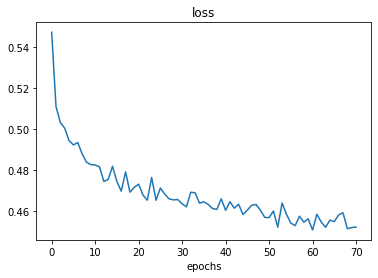

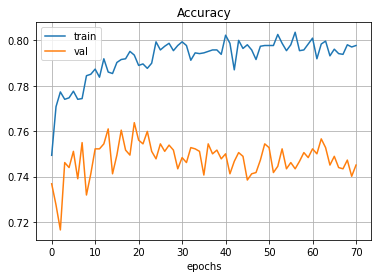

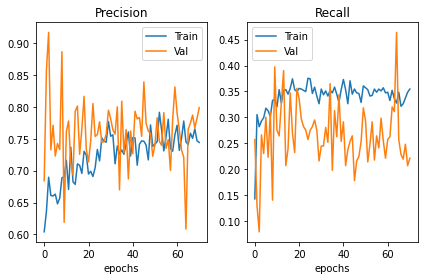

Test accuracy : 73 %
Test precision : 72 %
Test recall : 22 %
Model AUC : 59 %


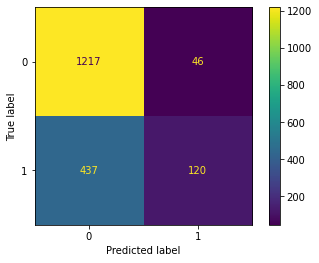

In [941]:
model=model_1(X_train,Y_train,X_val,Y_val,X_test,Y_test)
model.architecture
model.train(seed=123)
model.plot_all_training_metrics()
model.test()

Test accuracy : 74 %
Test precision : 74 %
Test recall : 23 %
Model AUC : 60 %


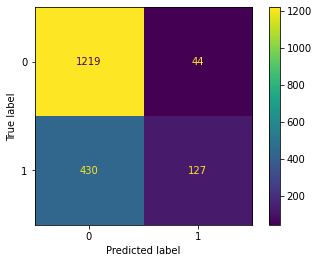

In [942]:
model=model_1(X_train,Y_train,X_val,Y_val,X_test,Y_test)
model.train(seed=321)
# model.plot_all_training_metrics()
model.test()

model 2

In [943]:
class model_2(DLModel):
    def __init__(self,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        
    def model_compiler(self):        
        MLP_model=keras.Sequential(
            [
                keras.Input(shape=(7,)),            
                keras.layers.Dense(10,activation='tanh', kernel_initializer="glorot_uniform"),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(10,activation='tanh'),
                keras.layers.Dropout(0.4),    
                keras.layers.Dense(6,activation='tanh'),
                keras.layers.Dense(6,activation='tanh'),
                keras.layers.Dropout(0.7),  
                keras.layers.Dense(10,activation='tanh'),
                keras.layers.Dense(1,activation='sigmoid')
            ]
            )
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
        model_loss=keras.losses.BinaryCrossentropy()
        model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
        model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
        MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)
        return MLP_model
    
    def training_params(self):
        epochs=300
        batch_size=32
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        return {'callbacks':[callback,tensorboard_callback],'epochs':epochs,'batch_size':batch_size}



Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_447 (Dense)           (None, 10)                80        
                                                                 
 batch_normalization_30 (Bat  (None, 10)               40        
 chNormalization)                                                
                                                                 
 dense_448 (Dense)           (None, 10)                110       
                                                                 
 dropout_97 (Dropout)        (None, 10)                0         
                                                                 
 dense_449 (Dense)           (None, 6)                 66        
                                                                 
 dense_450 (Dense)           (None, 6)                 42        
                                                     

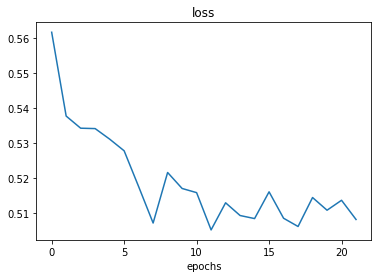

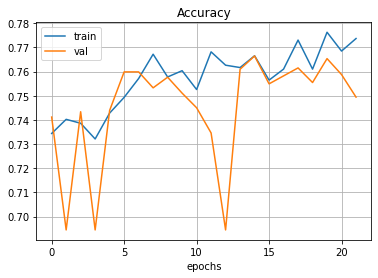

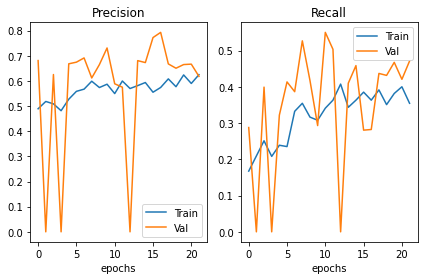

Test accuracy : 75 %
Test precision : 61 %
Test recall : 50 %
Model AUC : 68 %


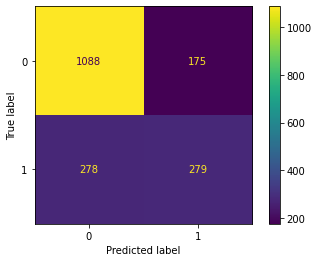

In [944]:
model=model_2(X_train,Y_train,X_val,Y_val,X_test,Y_test)
model.architecture
model.train(seed=123)
model.plot_all_training_metrics()
model.test()

Test accuracy : 75 %
Test precision : 64 %
Test recall : 38 %
Model AUC : 65 %


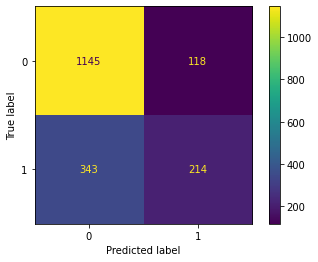

In [945]:
model=model_2(X_train,Y_train,X_val,Y_val,X_test,Y_test)
model.train(seed=123)
model.test()

model 3

In [946]:
class model_3(DLModel):
    def __init__(self,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        
    def model_compiler(self):        
        MLP_model=keras.Sequential(
            [
                keras.Input(shape=(7,)),            
                keras.layers.Dense(5,activation='tanh', kernel_initializer="glorot_uniform"),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(5,activation='tanh'),
                keras.layers.Dropout(0.4),    
                keras.layers.Dense(3,activation='tanh'),
                keras.layers.Dense(3,activation='tanh'),
                keras.layers.Dropout(0.7),  
                keras.layers.Dense(6,activation='tanh'),
                keras.layers.Dense(4,activation='tanh'),
                keras.layers.Dense(2,activation='tanh'),
                keras.layers.Dense(1,activation='sigmoid')
            ]
            )
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
        model_loss=keras.losses.BinaryCrossentropy()
        model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
        model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
        MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)

        return MLP_model
    
    def training_params(self):
        epochs=300
        batch_size=32
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        return {'callbacks':[callback,tensorboard_callback],'epochs':epochs,'batch_size':batch_size}



Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_459 (Dense)           (None, 5)                 40        
                                                                 
 batch_normalization_32 (Bat  (None, 5)                20        
 chNormalization)                                                
                                                                 
 dense_460 (Dense)           (None, 5)                 30        
                                                                 
 dropout_101 (Dropout)       (None, 5)                 0         
                                                                 
 dense_461 (Dense)           (None, 3)                 18        
                                                                 
 dense_462 (Dense)           (None, 3)                 12        
                                                     

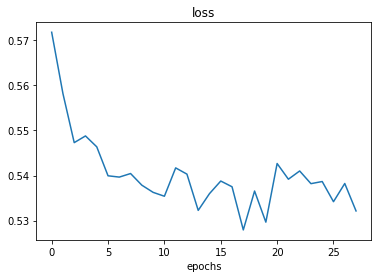

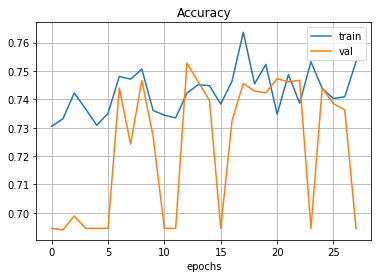

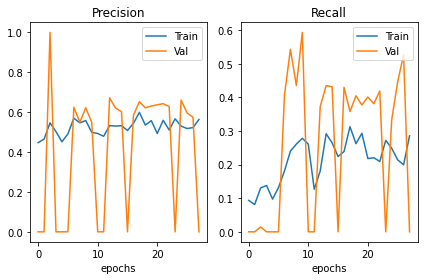

Test accuracy : 69 %
Test precision : 0 %
Test recall : 0 %
Model AUC : 50 %


c:\Users\estevan.amazonas\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


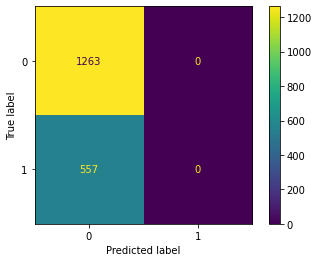

In [947]:
model=model_3(X_train,Y_train,X_val,Y_val,X_test,Y_test)
model.architecture
model.train(seed=123)
model.plot_all_training_metrics()
model.test()

Test accuracy : 74 %
Test precision : 59 %
Test recall : 47 %
Model AUC : 66 %


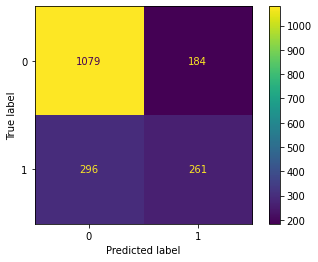

In [948]:
model=model_3(X_train,Y_train,X_val,Y_val,X_test,Y_test)
model.train(seed=123)
model.test()

model 4

In [949]:
class model_4(DLModel):
    def __init__(self,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        
    def model_compiler(self):        
        MLP_model=keras.Sequential(
            [
                keras.Input(shape=(7,)),            
                keras.layers.Dense(5,activation='selu', kernel_initializer="glorot_uniform"),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(5,activation='selu'),
                keras.layers.Dropout(0.4),    
                keras.layers.Dense(3,activation='selu'),
                keras.layers.Dense(3,activation='selu'),
                keras.layers.Dropout(0.7),  
                keras.layers.Dense(6,activation='selu'),
                keras.layers.Dense(4,activation='selu'),
                keras.layers.Dense(2,activation='selu'),
                keras.layers.Dense(1,activation='sigmoid')
            ]
            )
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
        model_loss=keras.losses.BinaryCrossentropy()
        model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
        model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
        MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)

        return MLP_model
    
    def training_params(self):
        epochs=300
        batch_size=32
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        return {'callbacks':[callback,tensorboard_callback],'epochs':epochs,'batch_size':batch_size}



Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_475 (Dense)           (None, 5)                 40        
                                                                 
 batch_normalization_34 (Bat  (None, 5)                20        
 chNormalization)                                                
                                                                 
 dense_476 (Dense)           (None, 5)                 30        
                                                                 
 dropout_105 (Dropout)       (None, 5)                 0         
                                                                 
 dense_477 (Dense)           (None, 3)                 18        
                                                                 
 dense_478 (Dense)           (None, 3)                 12        
                                                     

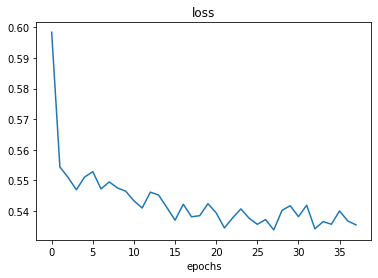

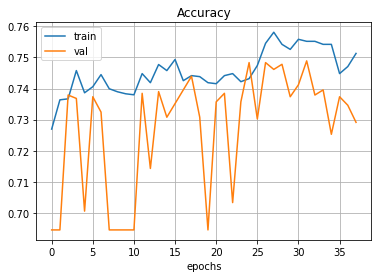

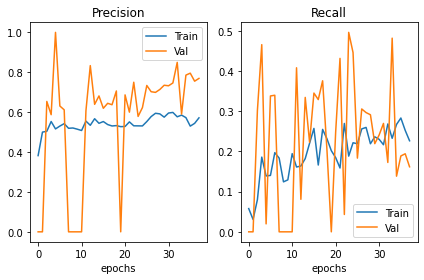

Test accuracy : 73 %
Test precision : 77 %
Test recall : 16 %
Model AUC : 57 %


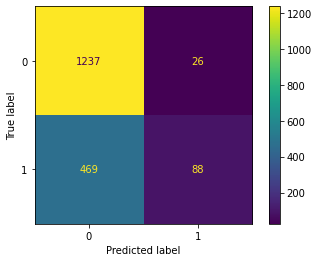

In [950]:
model=model_4(X_train,Y_train,X_val,Y_val,X_test,Y_test)
model.architecture
model.train(seed=123)
model.plot_all_training_metrics()
model.test()

model 5

In [951]:
class model_5(DLModel):
    def __init__(self,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        
    def model_compiler(self):        
        MLP_model=keras.Sequential(
            [
                keras.Input(shape=(7,)),            
                keras.layers.Dense(5,activation='tanh', kernel_initializer="glorot_uniform"),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(5,activation='tanh'),
                keras.layers.Dropout(0.4),    
                keras.layers.Dense(3,activation='tanh'),
                keras.layers.Dense(3,activation='tanh'),
                keras.layers.Dropout(0.7),  
                keras.layers.Dense(6,activation='tanh'),
                keras.layers.Dense(4,activation='tanh'),
                keras.layers.Dense(6,activation='tanh'),
                keras.layers.Dense(4,activation='tanh'),
                keras.layers.Dense(6,activation='tanh'),
                keras.layers.Dense(4,activation='tanh'),
                keras.layers.Dense(2,activation='tanh'),
                keras.layers.Dense(1,activation='sigmoid')
            ]
            )
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
        model_loss=keras.losses.BinaryCrossentropy()
        model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
        model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
        MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)

        return MLP_model
    
    def training_params(self):
        epochs=300
        batch_size=32
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        return {'callbacks':[callback,tensorboard_callback],'epochs':epochs,'batch_size':batch_size}



Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_483 (Dense)           (None, 5)                 40        
                                                                 
 batch_normalization_35 (Bat  (None, 5)                20        
 chNormalization)                                                
                                                                 
 dense_484 (Dense)           (None, 5)                 30        
                                                                 
 dropout_107 (Dropout)       (None, 5)                 0         
                                                                 
 dense_485 (Dense)           (None, 3)                 18        
                                                                 
 dense_486 (Dense)           (None, 3)                 12        
                                                     

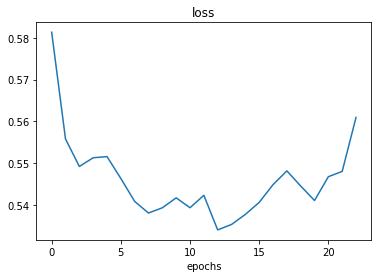

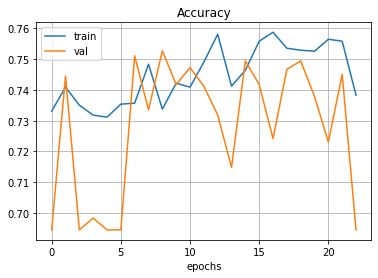

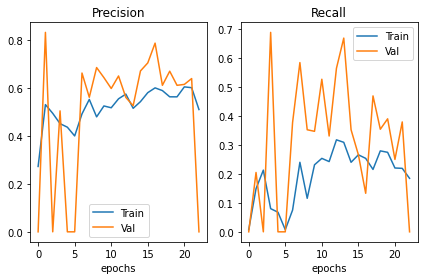

Test accuracy : 69 %
Test precision : 0 %
Test recall : 0 %
Model AUC : 50 %


c:\Users\estevan.amazonas\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


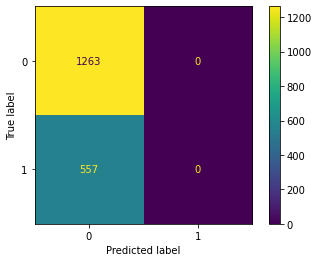

In [952]:
model=model_5(X_train,Y_train,X_val,Y_val,X_test,Y_test)
model.architecture
model.train(seed=123)
model.plot_all_training_metrics()
model.test()

model 6

In [953]:
class model_6(DLModel):
    def __init__(self,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        
    def model_compiler(self):        
        MLP_model=keras.Sequential(
            [
                keras.Input(shape=(7,)),            
                keras.layers.Dense(5,activation='tanh', kernel_initializer="glorot_uniform"),
                keras.layers.Dense(3,activation='tanh'),
                keras.layers.Dense(3,activation='tanh'),
                keras.layers.Dense(1,activation='sigmoid')
            ]
            )
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
        model_loss=keras.losses.BinaryCrossentropy()
        model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
        model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
        MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)

        return MLP_model
    
    def training_params(self):
        epochs=300
        batch_size=32
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        return {'callbacks':[callback,tensorboard_callback],'epochs':epochs,'batch_size':batch_size}



Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_495 (Dense)           (None, 5)                 40        
                                                                 
 dense_496 (Dense)           (None, 3)                 18        
                                                                 
 dense_497 (Dense)           (None, 3)                 12        
                                                                 
 dense_498 (Dense)           (None, 1)                 4         
                                                                 
Total params: 74
Trainable params: 74
Non-trainable params: 0
_________________________________________________________________


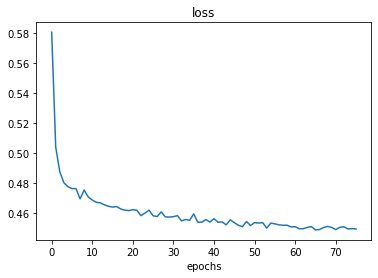

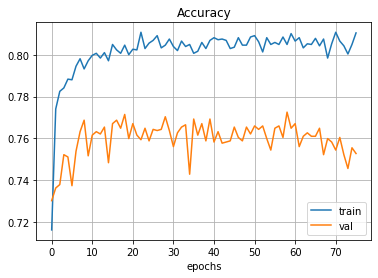

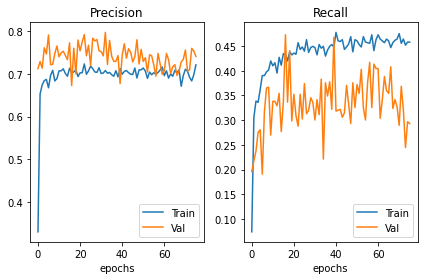

Test accuracy : 74 %
Test precision : 68 %
Test recall : 30 %
Model AUC : 62 %


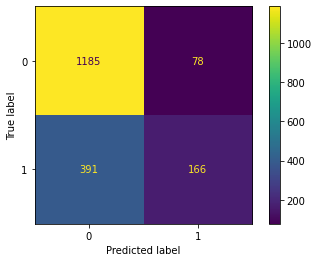

In [954]:
model=model_6(X_train,Y_train,X_val,Y_val,X_test,Y_test)
model.architecture
model.train(seed=123)
model.plot_all_training_metrics()
model.test()

Test accuracy : 75 %
Test precision : 69 %
Test recall : 30 %
Model AUC : 62 %


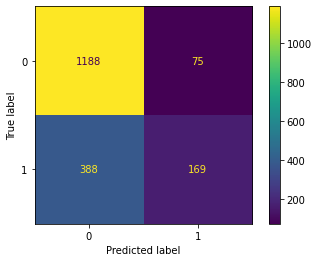

In [955]:
model=model_6(X_train,Y_train,X_val,Y_val,X_test,Y_test)
model.train(seed=321)
model.test()

In [956]:
%load_ext tensorboard
# %reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


#### CNN

### Recurrente Plot Aproach

Spiegel, S., Jain, J.-B., & Albayrak, S. (2014). A recurrence plot-based distance measure.

In [1369]:
@dataclass
class RecurrenceImageLoader(DataLoader):

    
    def ordenate_data(self,columns_order:list,images_depth:list):
        self.train_df=self.train_df[columns_order]
        self.test_df=self.test_df[columns_order]
        self.images_depth=images_depth
    

    def recurrence_plot_params(self,**kwargs):
        self.RecurrencePloter=RecurrencePlot(**kwargs)


    def generate_recurrence_plots(self):
        self.XtrainRPImgs=self.__recurrence_plots(self.XtrainSequence)
        self.XvalRPImgs=self.__recurrence_plots(self.XvalSequence)
        self.XtestRPImgs=self.__recurrence_plots(self.XtestSequence)
    
    def __recurrence_plots(self,Tensor)-> np.array:
        X_img_channels=[]
        for Matrix in Tensor:
                img_channels_temp=[]    
                for Vec in Matrix:
                  img_channels_temp.append(np.squeeze(self.RecurrencePloter.transform(Vec.reshape(-1,len(Vec))),axis=0))
                X_img_channels.append(img_channels_temp)

        return np.swapaxes(np.array(X_img_channels),1,-1)
    
    
    def customize_recurrance_plots(self):
        self.XtrainRPImgs=self.__customize_recurrence_plot(self.XtrainRPImgs)
        self.XvalRPImgs=self.__customize_recurrence_plot(self.XvalRPImgs)
        self.XtestRPImgs=self.__customize_recurrence_plot(self.XtestRPImgs)

    def __customize_recurrence_plot(self,imgs):      
        if hasattr(self,'images_depth'):
            depths=self.images_depth
        else:
            raise Exception("The method ordenate_data should be called before")
        new_imgs=[]
        for img in imgs:
            channels=0
            new_img_temp=[]
            for depth in depths:     
                new_img_temp.append(self.concat_channels(*np.swapaxes(img[:,:,range(channels,channels+depth)],-1,0)))
                channels+=depth
            new_imgs.append(self.concat_imgs(*new_img_temp))

        return np.array(new_imgs)

            

    @staticmethod
    def concat_channels(*args):
        rgb_img=np.stack((args),axis=-1)
        return rgb_img
    
    @staticmethod
    def concat_imgs(*args):
        concated_rgb_img=np.vstack((args))
        return concated_rgb_img
    
    def get_train_val_test_recurrence_img(self):
        if not hasattr(self,'XvalSequence'):
            self.get_train_val_test_sequence()
        self.generate_recurrence_plots()
        return self.XtrainRPImgs,self.YvalSequence,self.XvalRPImgs,self.YvalSequence,self.XtestRPImgs,self.YtestSequence

    def get_train_val_test_recurrence_img_customized(self):
        if not hasattr(self,'XvalSequence'):
            self.get_train_val_test_sequence()
        self.generate_recurrence_plots()
        self.customize_recurrance_plots()

        return self.XtrainRPImgs,self.YvalSequence,self.XvalRPImgs,self.YvalSequence,self.XtestRPImgs,self.YtestSequence



        
                    
                    

In [1370]:
dataloader=RecurrenceImageLoader(train_data.copy(),test_data.copy(),var_columns,['class_code'])
map={0:1,2:0,1:0}
dataloader.to_binary_classes(map)
dataloader.smoothing('gaussian',window=5,std=3)
dataloader.to_sequecence(10)

In [1371]:
dataloader.recurrence_plot_params(threshold=0.5)
# X_train_img,Y_train_img,X_val_img,Y_val_img,X_test_img,Y_test=dataloader.get_train_val_test_recurrence_img()
# X_train_img.shape

In [1372]:
columns_order=['GyroX', 'GyroY', 'GyroZ','AccX', 'AccY', 'AccZ']
depths=[3,3]
dataloader.ordenate_data(columns_order,depths)
X_train_img,Y_train_img,X_val_img,Y_val_img,X_test_img,Y_test=dataloader.get_train_val_test_recurrence_img_customized()
X_train_img.shape

(3062, 20, 10, 3)

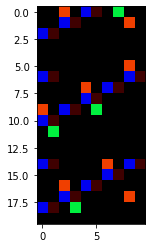

In [1373]:
a=PIL.Image.fromarray(X_train_img[0],mode="RGB")
plt.imshow(a)

In [ ]:
class modelCNN_1(DLModel):
    def __init__(self,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)

    def model_compiler(self):
        r=0.25
        n=5
        m=6
        alpha=0.2

        MLP_model=keras.Sequential(
                    [
                    keras.Input(),
                    keras.layers.Conv2D(filters=n,),
                    tf.keras.layers.LeakyReLU(alpha),
                    keras.layers.Conv2D(filters=2*n,);
                    tf.keras.layers.LeakyReLU(alpha),
                    keras.layers.MaxPooling2D(),
                    keras.layers.Dropout(r),
                    # keras.layers.Conv2D(filters=2*n),
                    # tf.keras.layers.LeakyReLU(alpha),
                    # keras.layers.MaxPooling2D(),
                    # keras.layers.Dropout(r),
                    keras.layers.GlobalMaxPool2D(),
                    keras.layers.Dense(m,activation='relu'),
                    keras.Dense(int(m/6),activation='softmax') 
                    ]
                    )
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
        model_loss=keras.losses.BinaryCrossentropy()
        model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
        model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
        MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)
        return MLP_model

    def training_params(self):
        epochs=300
        batch_size=32
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        return {'callbacks':[callback,tensorboard_callback],'epochs':epochs,'batch_size':batch_size}


    

Transfer Learning

#### RNN